In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [ ]:
file = pd.read_csv("initial_cleaned_winner_data.csv")
file.fillna(0, inplace=True)

In [5]:
y = pd.DataFrame(file['Winner'].astype(float))
X = file.drop(['Winner'], axis=1)

In [6]:
X.head()

raceId  season  raceNumber  Grand Prix  Race Date  Driver Code  Team Code  \
0       1    2009           1         2.0   20090329           18         23   
1       1    2009           1         2.0   20090329           22         23   
2       1    2009           1         2.0   20090329           15          7   
3       1    2009           1         2.0   20090329           10          7   
4       1    2009           1         2.0   20090329            4          4   

   Driver POS Standings  Laps  Team Race Points  ...  Team Country  \
0                     1    58              18.0  ...           2.0   
1                     2    58              18.0  ...           2.0   
2                    20    58              11.0  ...           9.0   
3                    19    58              11.0  ...           9.0   
4                    10    58               4.0  ...           4.0   

   Team Champ Points  Team Champ Pos  Team Champ Wins  Driver Champ Points  \
0               18.0             1.0              1.0                 10.0   
1               18.0             1.0              1.0                  8.0   
2               11.0             2.0              0.0                  6.0   
3               11.0             2.0              0.0                  5.0   
4                4.0             3.0              0.0                  4.0   

   Driver Champ Pos  Driver Champ Wins  Circuit Name  Race Location  \
0               1.0                1.0           0.0           14.0   
1               2.0                0.0           0.0           14.0   
2               3.0                0.0           0.0           14.0   
3               4.0                0.0           0.0           14.0   
4               5.0                0.0           0.0           14.0   

   Race Country  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  

[5 rows x 22 columns]

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, shuffle=False)

In [8]:
X_train.head()

raceId  season  raceNumber  Grand Prix  Race Date  Driver Code  Team Code  \
0       1    2009           1         2.0   20090329           18         23   
1       1    2009           1         2.0   20090329           22         23   
2       1    2009           1         2.0   20090329           15          7   
3       1    2009           1         2.0   20090329           10          7   
4       1    2009           1         2.0   20090329            4          4   

   Driver POS Standings  Laps  Team Race Points  ...  Team Country  \
0                     1    58              18.0  ...           2.0   
1                     2    58              18.0  ...           2.0   
2                    20    58              11.0  ...           9.0   
3                    19    58              11.0  ...           9.0   
4                    10    58               4.0  ...           4.0   

   Team Champ Points  Team Champ Pos  Team Champ Wins  Driver Champ Points  \
0               18.0             1.0              1.0                 10.0   
1               18.0             1.0              1.0                  8.0   
2               11.0             2.0              0.0                  6.0   
3               11.0             2.0              0.0                  5.0   
4                4.0             3.0              0.0                  4.0   

   Driver Champ Pos  Driver Champ Wins  Circuit Name  Race Location  \
0               1.0                1.0           0.0           14.0   
1               2.0                0.0           0.0           14.0   
2               3.0                0.0           0.0           14.0   
3               4.0                0.0           0.0           14.0   
4               5.0                0.0           0.0           14.0   

   Race Country  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  

[5 rows x 22 columns]

In [9]:
y_train.shape

(6870, 1)

In [10]:
class WinnerClassifier(nn.Module):
    def __init__(self, input_size, hidden, output_size):
        super(WinnerClassifier, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden)  # Hidden layer 1
        self.hidden2 = nn.Linear(hidden, hidden)  # Hidden layer 2
        self.output = nn.Linear(hidden, output_size)  # Output layer
        self.relu = nn.ReLU()  # Activation function
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.output(x)
        return self.sigmoid(x)

In [11]:
# Model parameters
input_size = 22
hidden = 22*2
output_size = 1

# Instantiate the model
model = WinnerClassifier(input_size, hidden, output_size)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Adam optimizer

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

WinnerClassifier(
  (hidden1): Linear(in_features=22, out_features=44, bias=True)
  (hidden2): Linear(in_features=44, out_features=44, bias=True)
  (output): Linear(in_features=44, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [21]:
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # For binary classification, ensure labels are float
            labels = labels.float()
            
            # Forward pass
            outputs = model(inputs)
           
            # Use binary cross entropy loss 
            loss = criterion(outputs, labels)
           
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
           
            optimizer.step()
            running_loss += loss.item()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        true_positives = 0
        total_positives = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                # Ensure labels are float for binary classification
                labels = labels.float()
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                # Binary classification prediction (using 0.5 as threshold)
                predicted = (outputs > 0.5).float()
                
                # Calculate components for recall
                true_positives += ((predicted == 1) & (labels == 1)).float().sum().item()
                total_positives += labels.sum().item()
        
        # Calculate recall (sensitivity / true positive rate)
        recall = true_positives / total_positives * 100 if total_positives > 0 else 0

        # Epoch statistics
        train_loss = running_loss / len(train_loader)
        val_loss = val_loss / len(val_loader)
        print(f"Epoch {epoch + 1}/{epochs}, "
              f"Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Recall: {recall:.2f}%")

        # Gather all true labels and predictions
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                labels = labels.float()
                outputs = model(inputs)
                predicted = (outputs > 0.5).float()
                all_labels.extend(labels.cpu().numpy())
                all_predictions.extend(predicted.cpu().numpy())

        # Compute confusion matrix
        cm = confusion_matrix(all_labels, all_predictions)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Class 0", "Class 1"])

        # Plot confusion matrix
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f"Confusion Matrix (Epoch {epoch + 1})")
        plt.show()


In [14]:
def prepare_data(X_train, X_val, y_train, y_val, batch_size=32):
   
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    
    # Convert to PyTorch tensors
    # Ensure labels are float for binary classification
    train_dataset = TensorDataset(torch.tensor(np.array(X_train), dtype=torch.float32),
                                   torch.tensor(np.array(y_train), dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(np.array(X_val), dtype=torch.float32),
                                 torch.tensor(np.array(y_val), dtype=torch.float32))
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
   
    return train_loader, val_loader

In [15]:
train_data, val_data = prepare_data(X_train, X_val, y_train, y_val)

Epoch 1/100, Train Loss: 0.5564, Val Loss: 0.4015, Recall: 0.00%


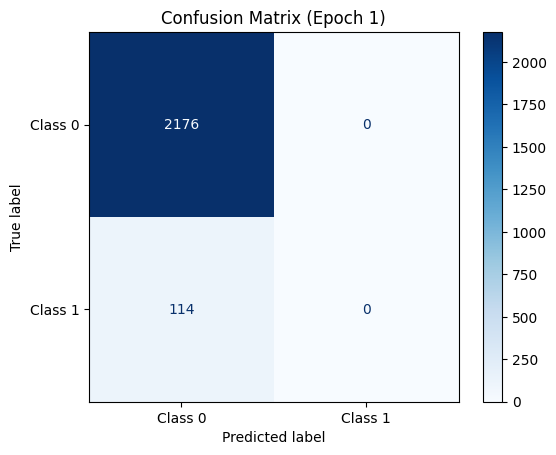

Epoch 2/100, Train Loss: 0.3388, Val Loss: 0.2106, Recall: 0.00%


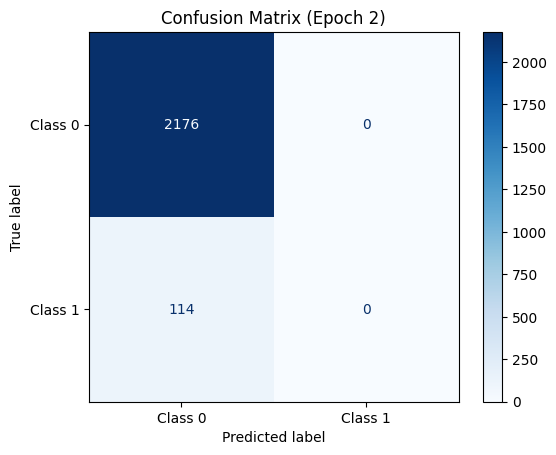

Epoch 3/100, Train Loss: 0.1959, Val Loss: 0.1588, Recall: 0.00%


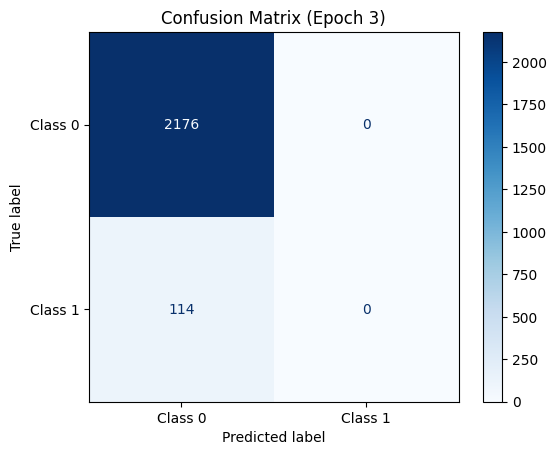

Epoch 4/100, Train Loss: 0.1471, Val Loss: 0.1409, Recall: 0.00%


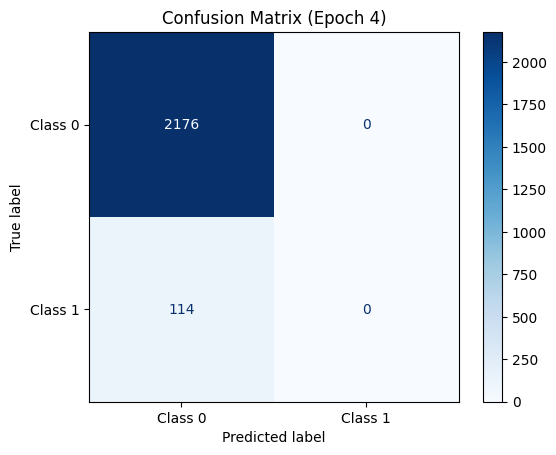

Epoch 5/100, Train Loss: 0.1277, Val Loss: 0.1320, Recall: 0.00%


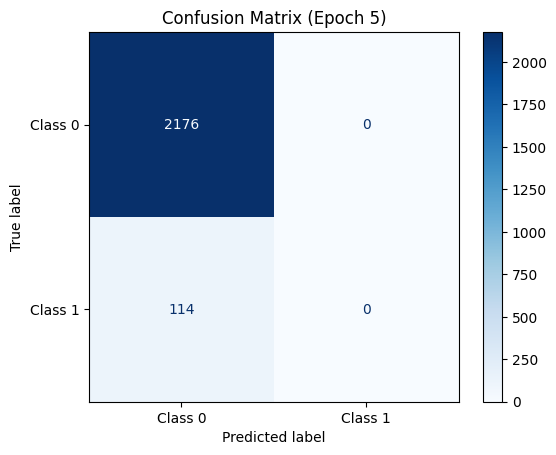

Epoch 6/100, Train Loss: 0.1173, Val Loss: 0.1256, Recall: 0.00%


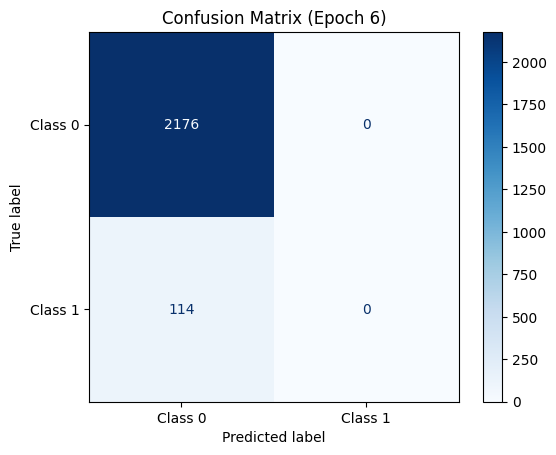

Epoch 7/100, Train Loss: 0.1104, Val Loss: 0.1220, Recall: 0.00%


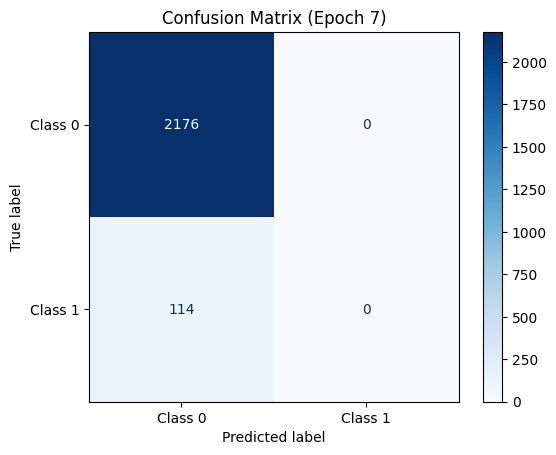

Epoch 8/100, Train Loss: 0.1049, Val Loss: 0.1189, Recall: 0.00%


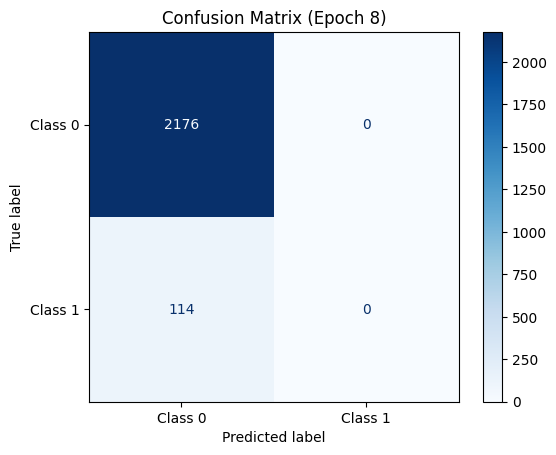

Epoch 9/100, Train Loss: 0.1004, Val Loss: 0.1179, Recall: 0.00%


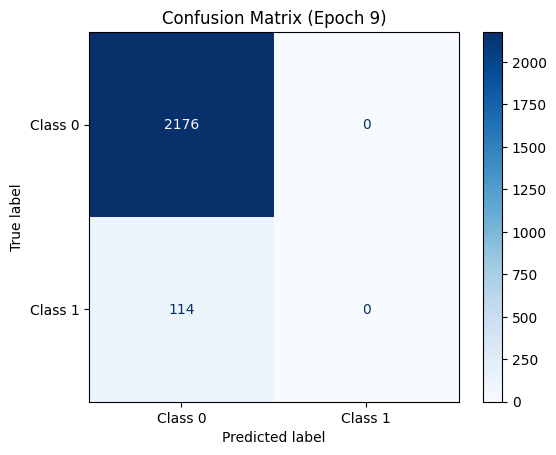

Epoch 10/100, Train Loss: 0.0967, Val Loss: 0.1160, Recall: 1.75%


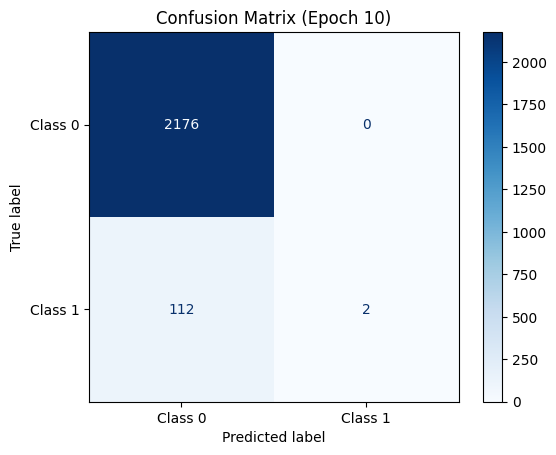

Epoch 11/100, Train Loss: 0.0932, Val Loss: 0.1155, Recall: 6.14%


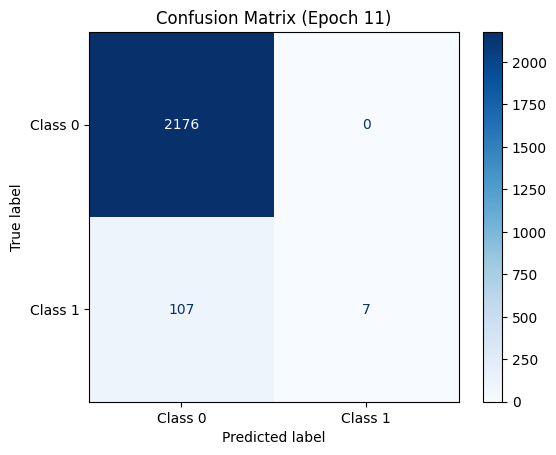

Epoch 12/100, Train Loss: 0.0904, Val Loss: 0.1138, Recall: 9.65%


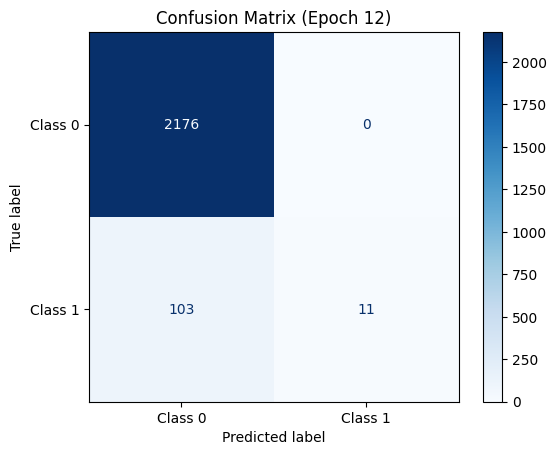

Epoch 13/100, Train Loss: 0.0883, Val Loss: 0.1134, Recall: 11.40%


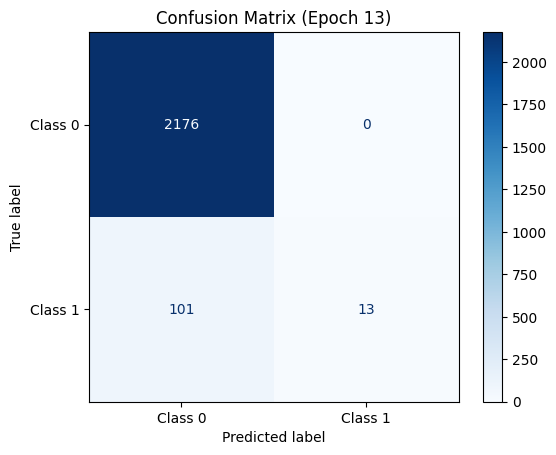

Epoch 14/100, Train Loss: 0.0859, Val Loss: 0.1144, Recall: 12.28%


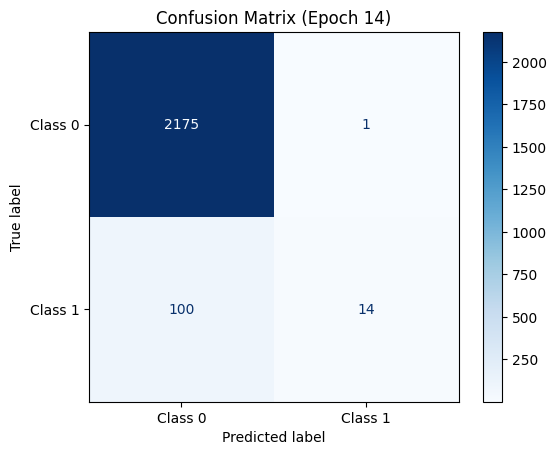

Epoch 15/100, Train Loss: 0.0839, Val Loss: 0.1107, Recall: 18.42%


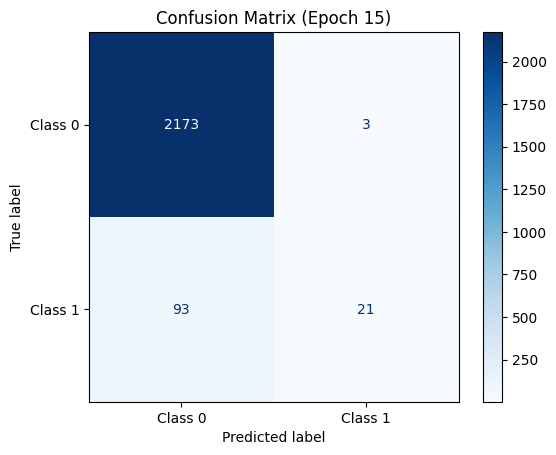

Epoch 16/100, Train Loss: 0.0822, Val Loss: 0.1112, Recall: 17.54%


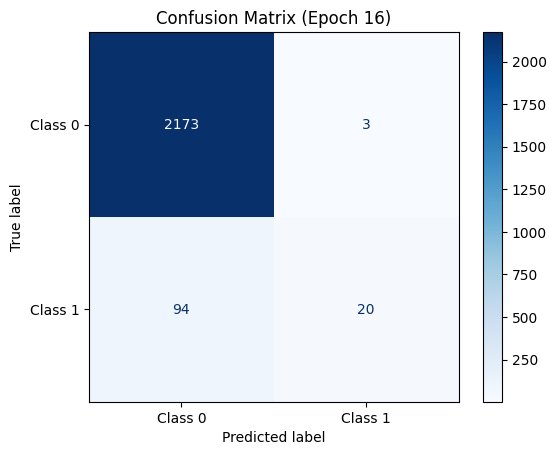

Epoch 17/100, Train Loss: 0.0806, Val Loss: 0.1103, Recall: 20.18%


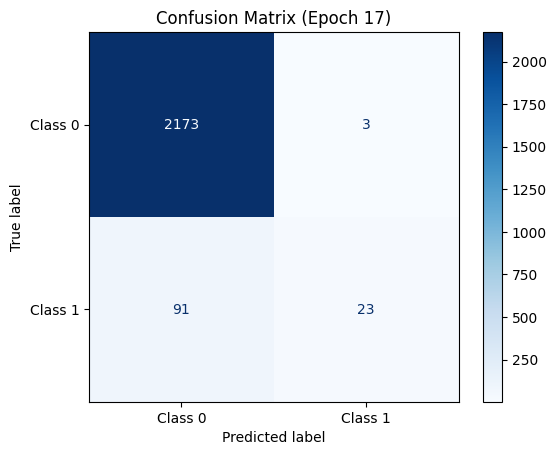

Epoch 18/100, Train Loss: 0.0793, Val Loss: 0.1071, Recall: 27.19%


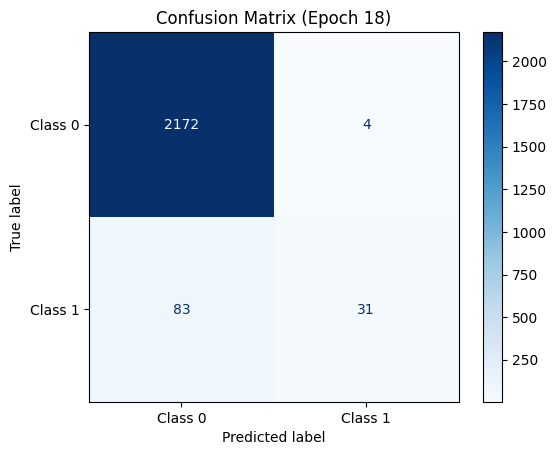

Epoch 19/100, Train Loss: 0.0782, Val Loss: 0.1087, Recall: 25.44%


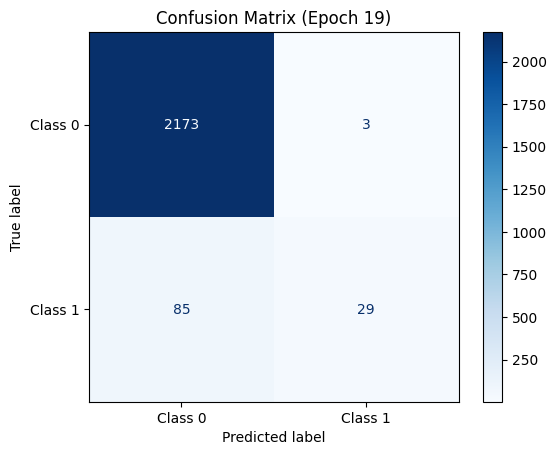

Epoch 20/100, Train Loss: 0.0768, Val Loss: 0.1078, Recall: 27.19%


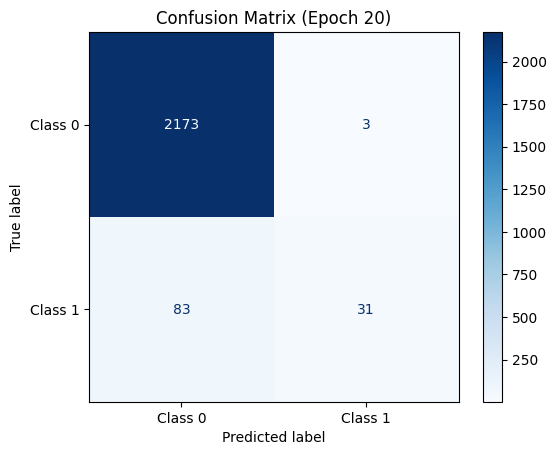

Epoch 21/100, Train Loss: 0.0758, Val Loss: 0.1091, Recall: 24.56%


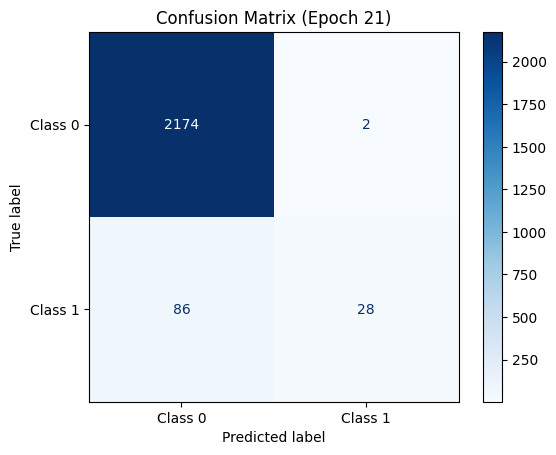

Epoch 22/100, Train Loss: 0.0747, Val Loss: 0.1048, Recall: 30.70%


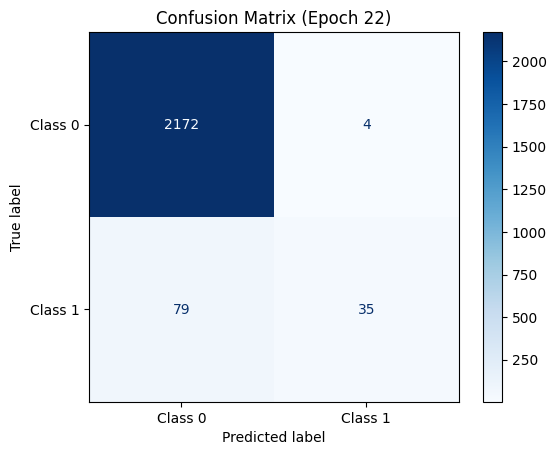

Epoch 23/100, Train Loss: 0.0737, Val Loss: 0.1070, Recall: 28.07%


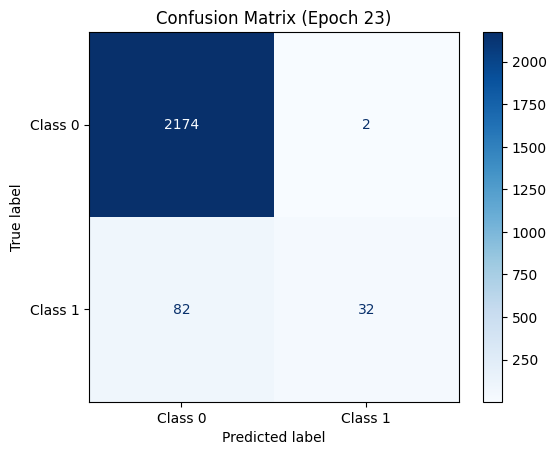

Epoch 24/100, Train Loss: 0.0728, Val Loss: 0.1050, Recall: 28.95%


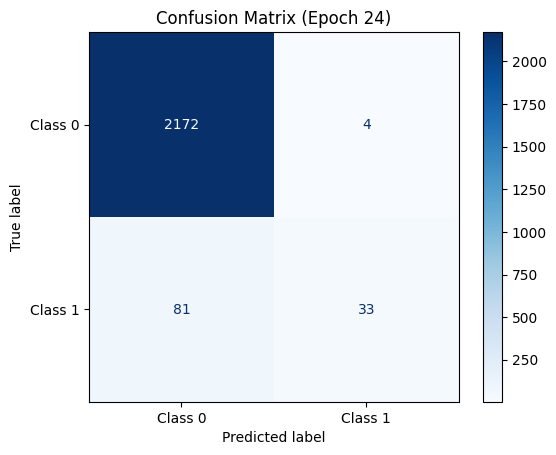

Epoch 25/100, Train Loss: 0.0723, Val Loss: 0.1025, Recall: 34.21%


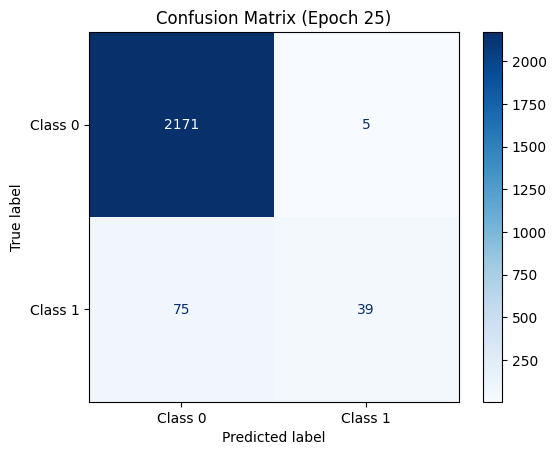

Epoch 26/100, Train Loss: 0.0713, Val Loss: 0.1046, Recall: 29.82%


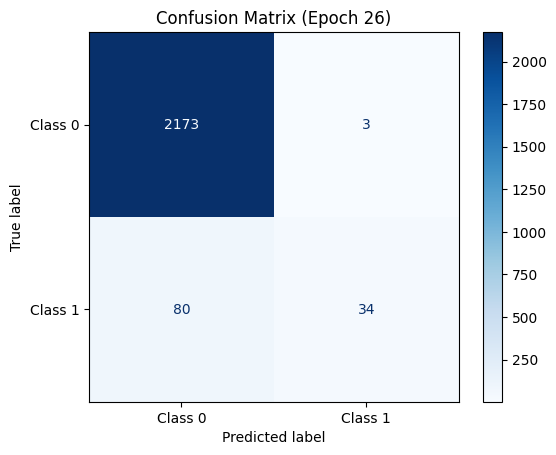

Epoch 27/100, Train Loss: 0.0708, Val Loss: 0.1056, Recall: 28.07%


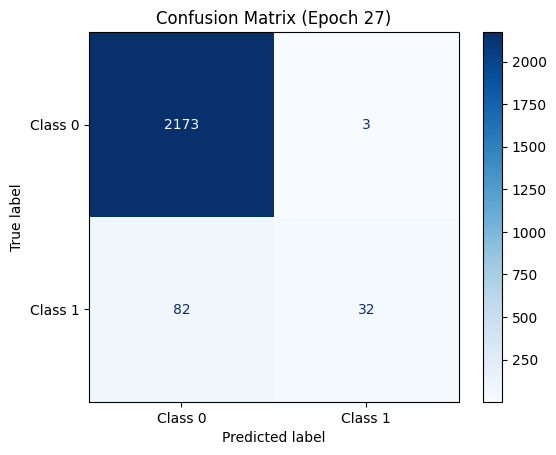

Epoch 28/100, Train Loss: 0.0699, Val Loss: 0.1018, Recall: 35.09%


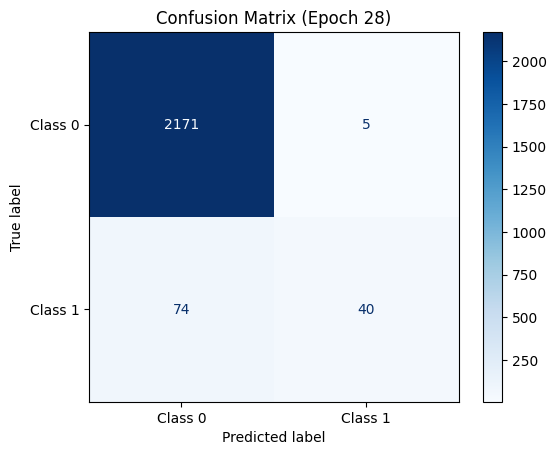

Epoch 29/100, Train Loss: 0.0693, Val Loss: 0.1044, Recall: 28.95%


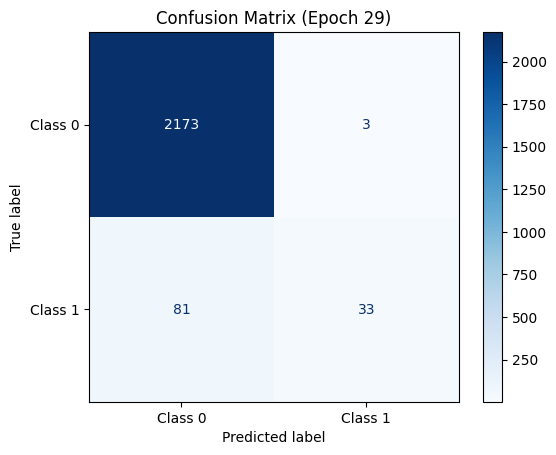

Epoch 30/100, Train Loss: 0.0689, Val Loss: 0.1039, Recall: 30.70%


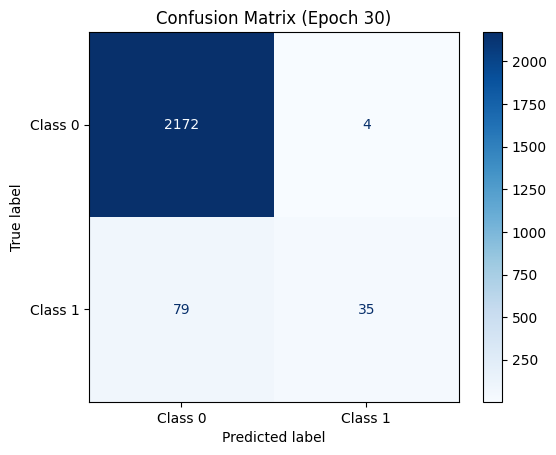

Epoch 31/100, Train Loss: 0.0684, Val Loss: 0.1003, Recall: 36.84%


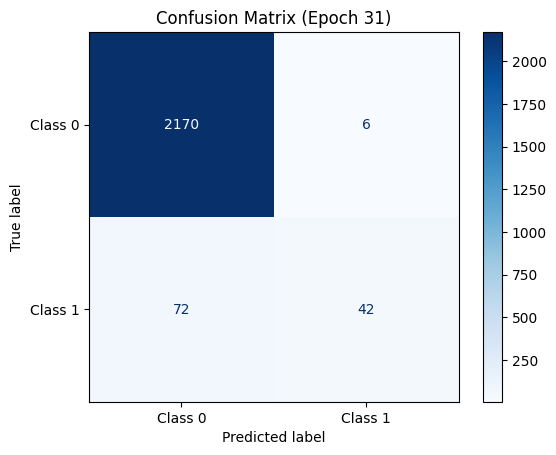

Epoch 32/100, Train Loss: 0.0676, Val Loss: 0.1011, Recall: 35.96%


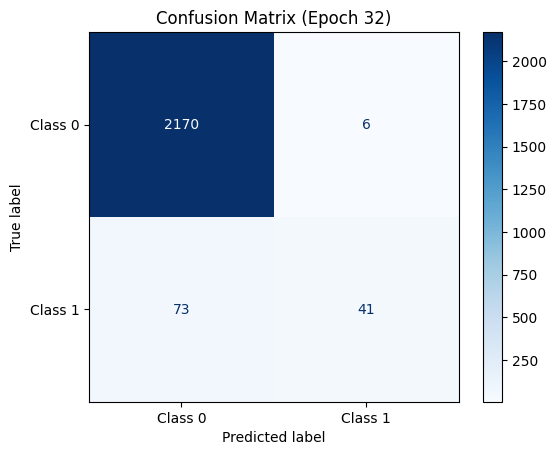

Epoch 33/100, Train Loss: 0.0671, Val Loss: 0.1017, Recall: 35.09%


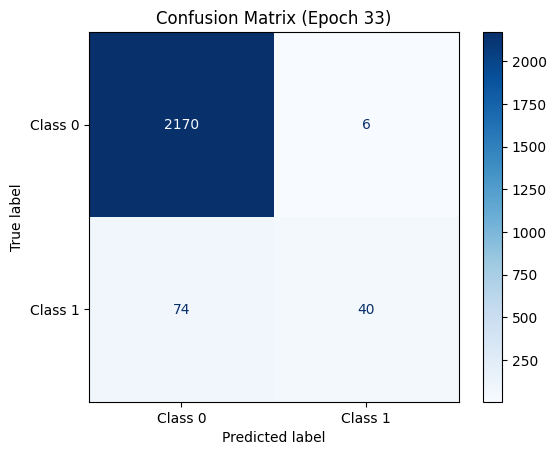

Epoch 34/100, Train Loss: 0.0664, Val Loss: 0.1026, Recall: 31.58%


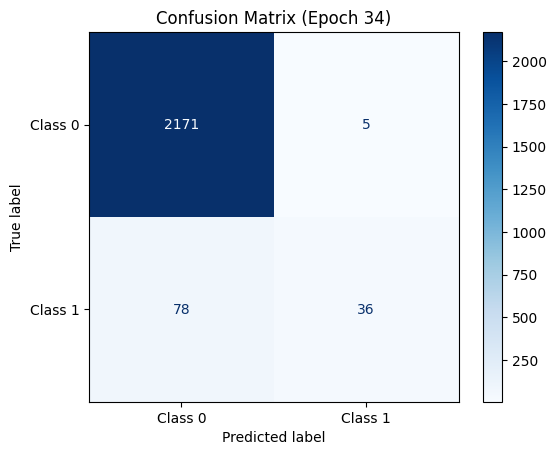

Epoch 35/100, Train Loss: 0.0660, Val Loss: 0.1011, Recall: 35.96%


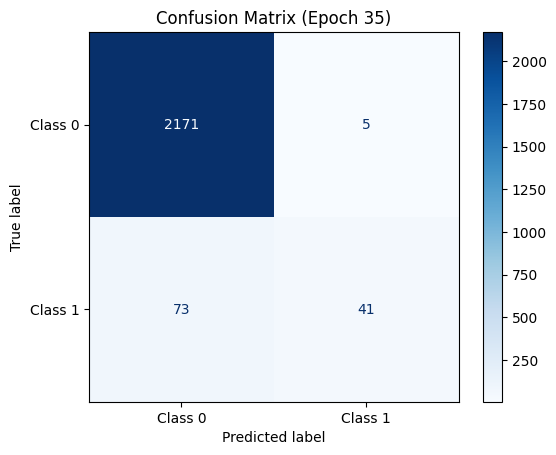

Epoch 36/100, Train Loss: 0.0657, Val Loss: 0.1008, Recall: 35.96%


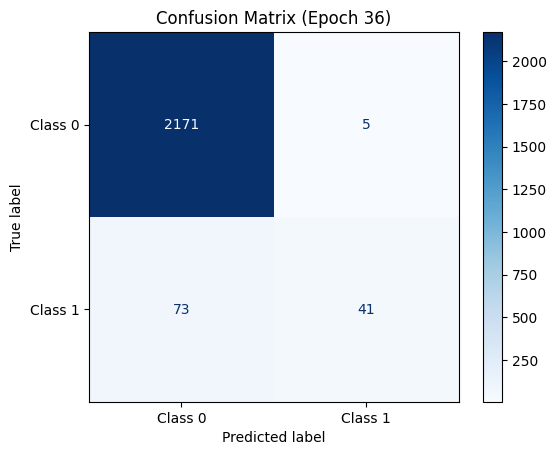

Epoch 37/100, Train Loss: 0.0651, Val Loss: 0.1025, Recall: 32.46%


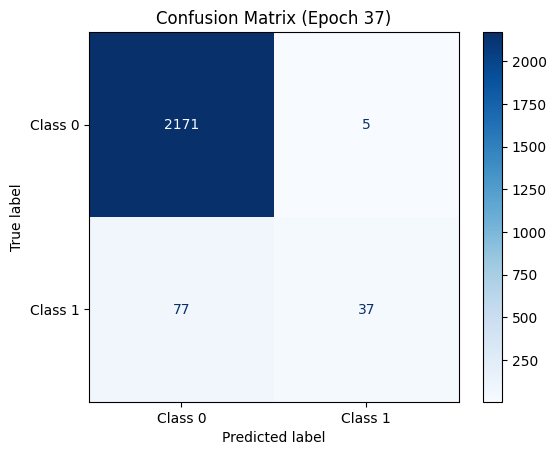

Epoch 38/100, Train Loss: 0.0647, Val Loss: 0.1008, Recall: 37.72%


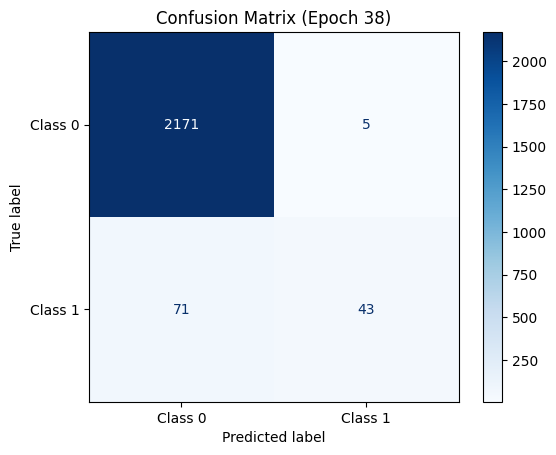

Epoch 39/100, Train Loss: 0.0642, Val Loss: 0.1010, Recall: 37.72%


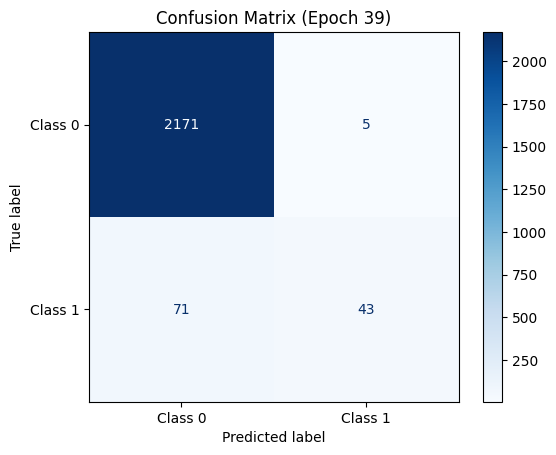

Epoch 40/100, Train Loss: 0.0638, Val Loss: 0.0978, Recall: 41.23%


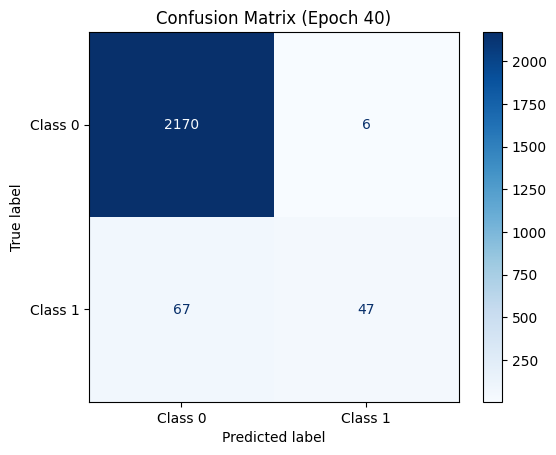

Epoch 41/100, Train Loss: 0.0634, Val Loss: 0.0974, Recall: 42.11%


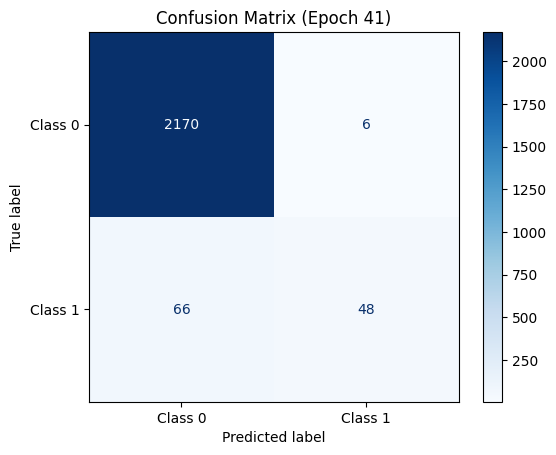

Epoch 42/100, Train Loss: 0.0629, Val Loss: 0.0987, Recall: 38.60%


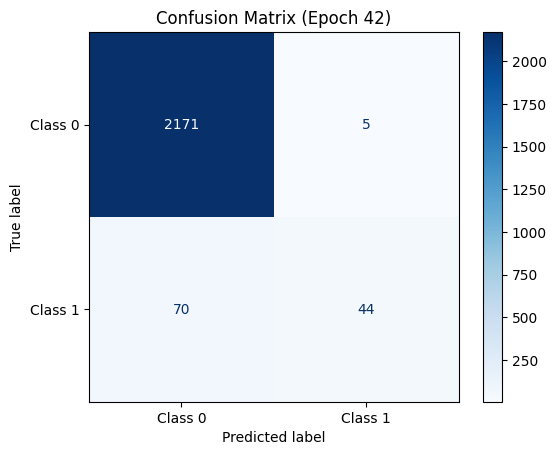

Epoch 43/100, Train Loss: 0.0626, Val Loss: 0.0969, Recall: 41.23%


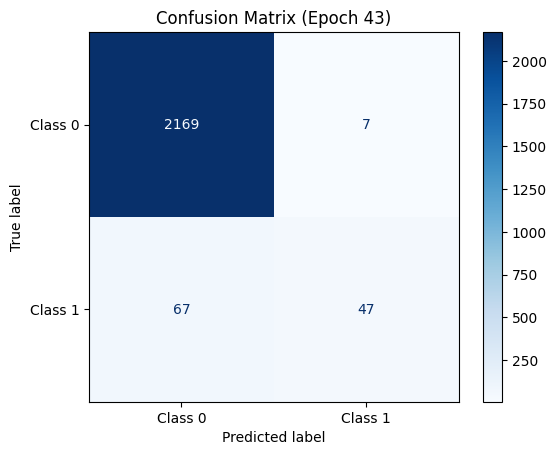

Epoch 44/100, Train Loss: 0.0622, Val Loss: 0.0964, Recall: 44.74%


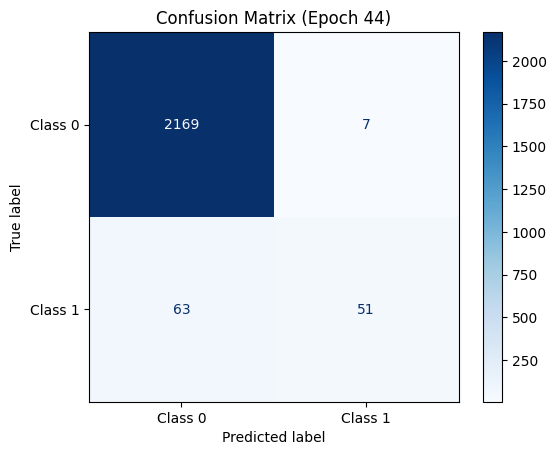

Epoch 45/100, Train Loss: 0.0619, Val Loss: 0.0942, Recall: 45.61%


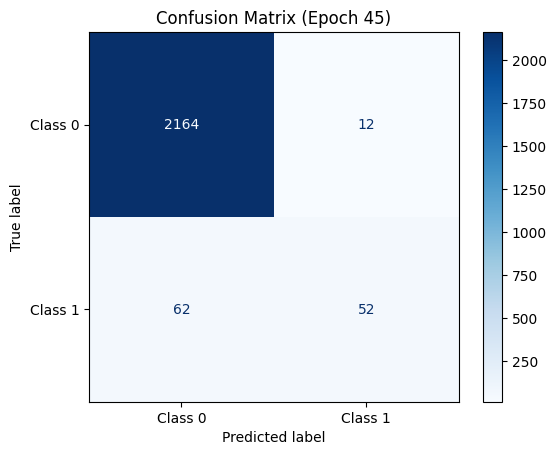

Epoch 46/100, Train Loss: 0.0615, Val Loss: 0.0953, Recall: 45.61%


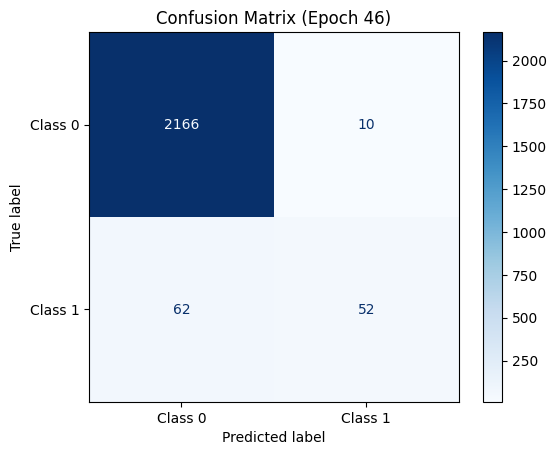

Epoch 47/100, Train Loss: 0.0614, Val Loss: 0.0939, Recall: 45.61%


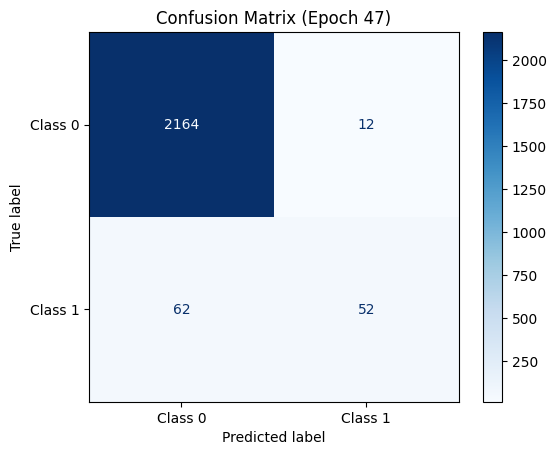

Epoch 48/100, Train Loss: 0.0609, Val Loss: 0.0956, Recall: 44.74%


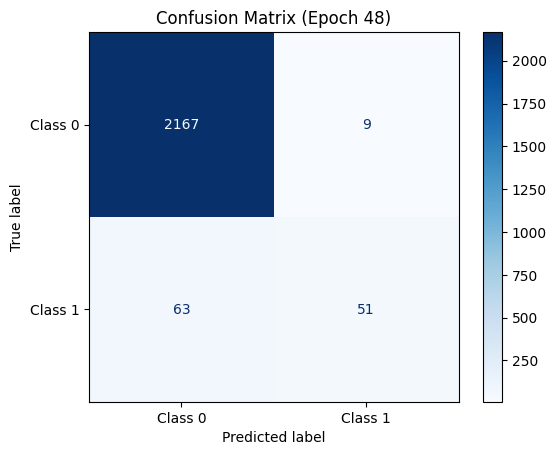

Epoch 49/100, Train Loss: 0.0605, Val Loss: 0.0961, Recall: 43.86%


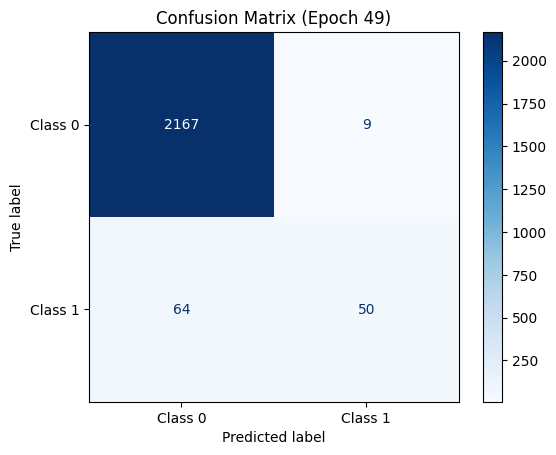

Epoch 50/100, Train Loss: 0.0601, Val Loss: 0.0947, Recall: 44.74%


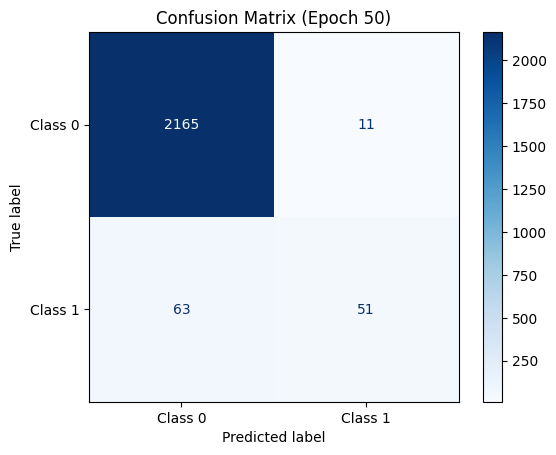

Epoch 51/100, Train Loss: 0.0598, Val Loss: 0.0956, Recall: 43.86%


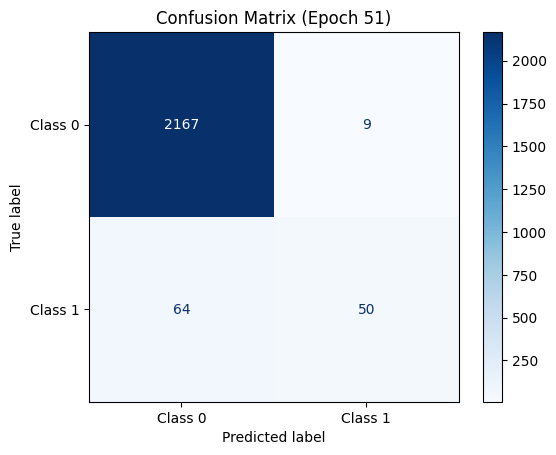

Epoch 52/100, Train Loss: 0.0595, Val Loss: 0.0944, Recall: 44.74%


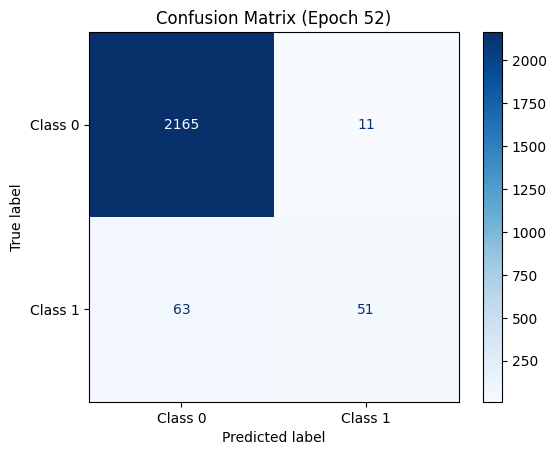

Epoch 53/100, Train Loss: 0.0591, Val Loss: 0.0941, Recall: 45.61%


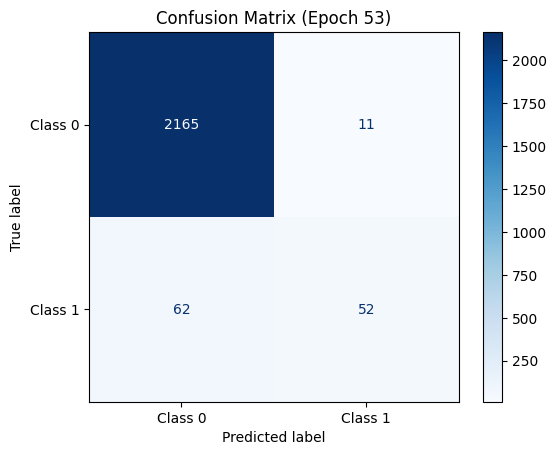

Epoch 54/100, Train Loss: 0.0588, Val Loss: 0.0928, Recall: 47.37%


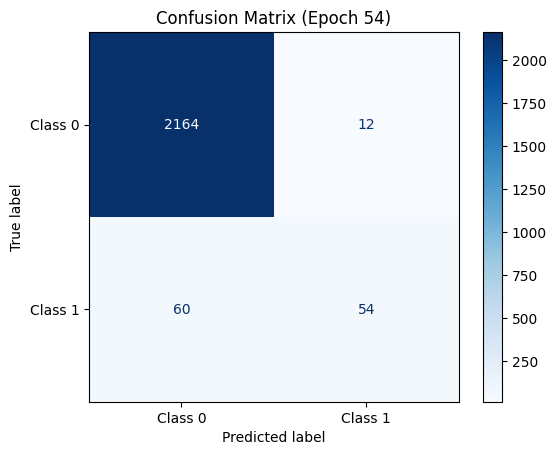

Epoch 55/100, Train Loss: 0.0586, Val Loss: 0.0934, Recall: 47.37%


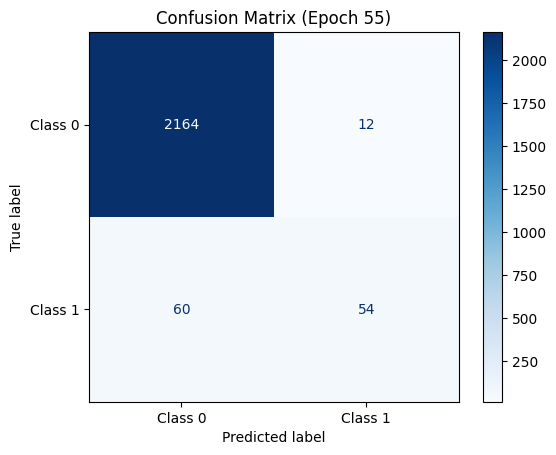

Epoch 56/100, Train Loss: 0.0582, Val Loss: 0.0969, Recall: 42.11%


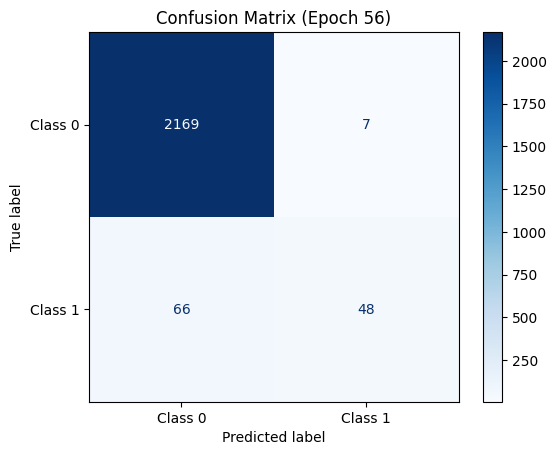

Epoch 57/100, Train Loss: 0.0582, Val Loss: 0.0945, Recall: 47.37%


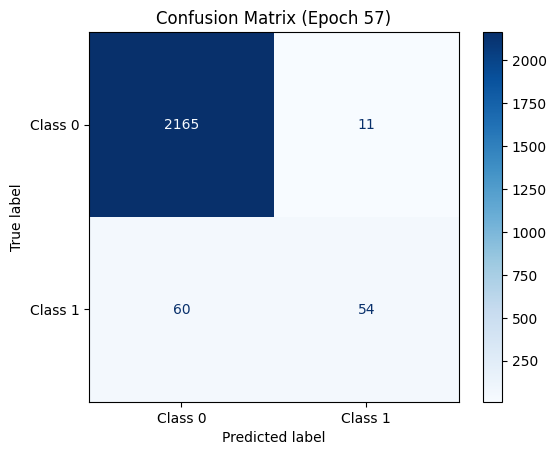

Epoch 58/100, Train Loss: 0.0578, Val Loss: 0.0967, Recall: 42.98%


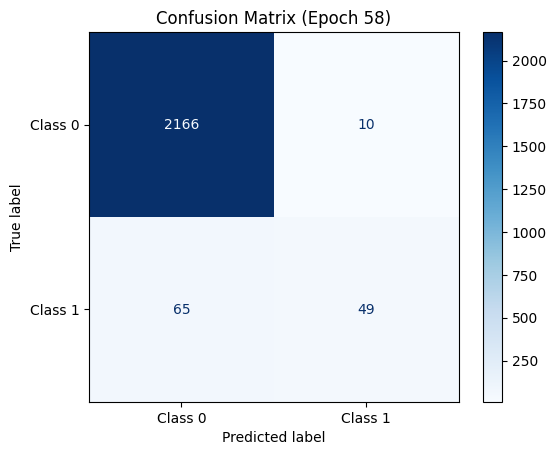

Epoch 59/100, Train Loss: 0.0575, Val Loss: 0.0954, Recall: 47.37%


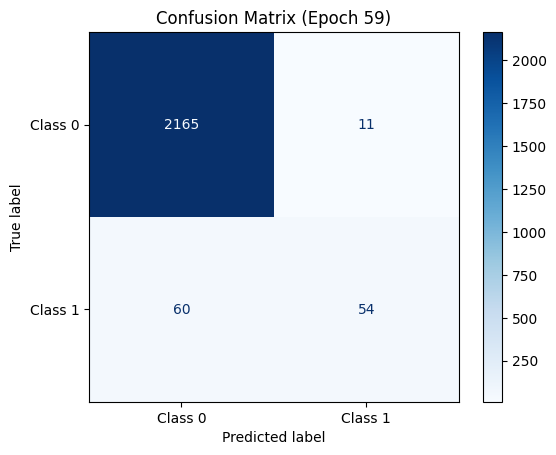

Epoch 60/100, Train Loss: 0.0572, Val Loss: 0.0951, Recall: 48.25%


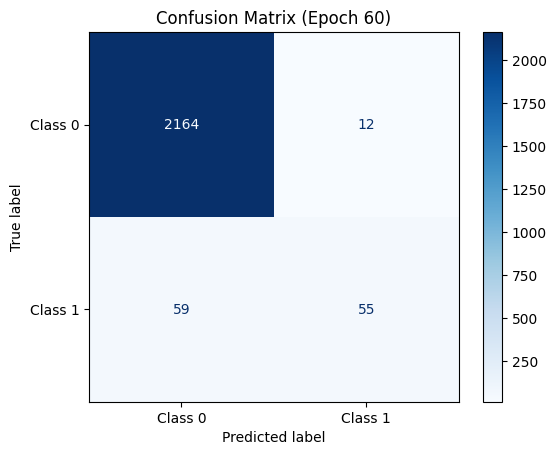

Epoch 61/100, Train Loss: 0.0570, Val Loss: 0.0947, Recall: 48.25%


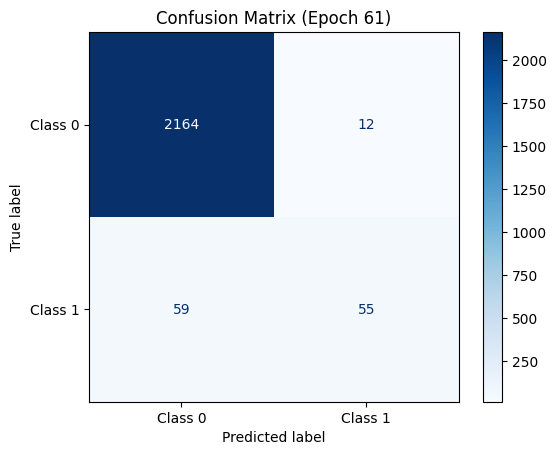

Epoch 62/100, Train Loss: 0.0568, Val Loss: 0.0928, Recall: 48.25%


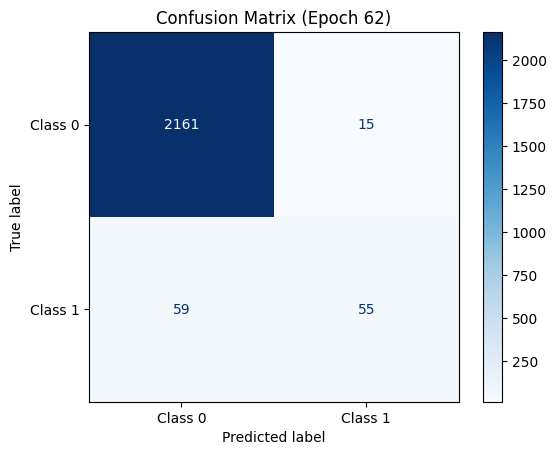

Epoch 63/100, Train Loss: 0.0566, Val Loss: 0.0938, Recall: 48.25%


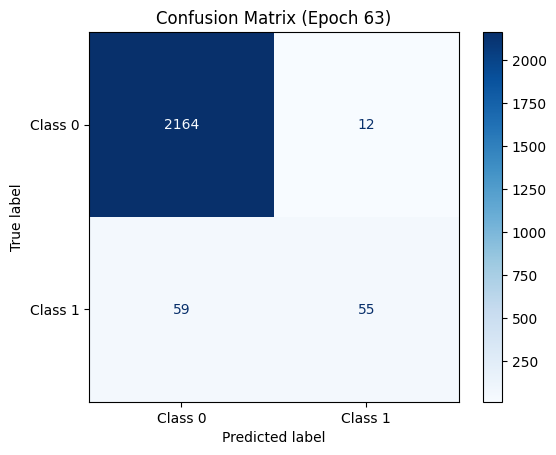

Epoch 64/100, Train Loss: 0.0563, Val Loss: 0.0933, Recall: 48.25%


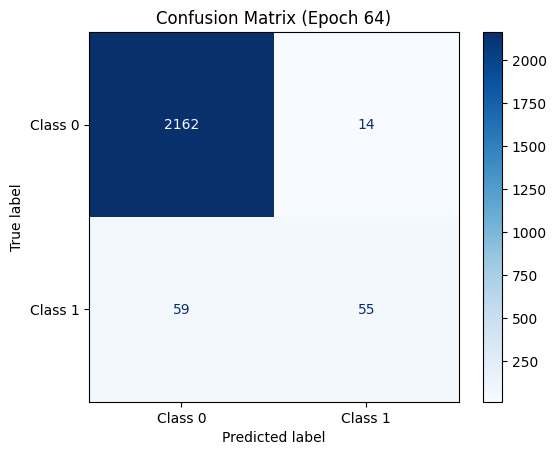

Epoch 65/100, Train Loss: 0.0561, Val Loss: 0.0938, Recall: 48.25%


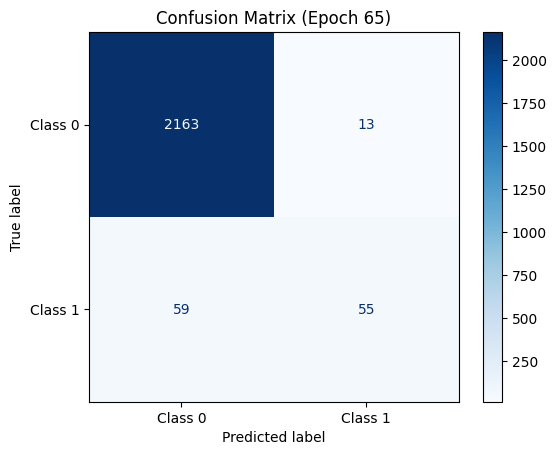

Epoch 66/100, Train Loss: 0.0559, Val Loss: 0.0938, Recall: 48.25%


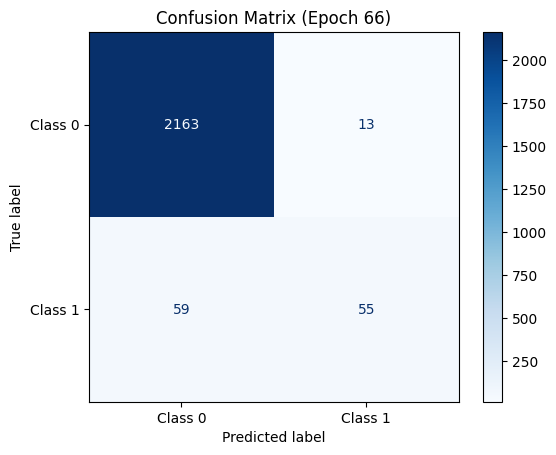

Epoch 67/100, Train Loss: 0.0557, Val Loss: 0.0970, Recall: 43.86%


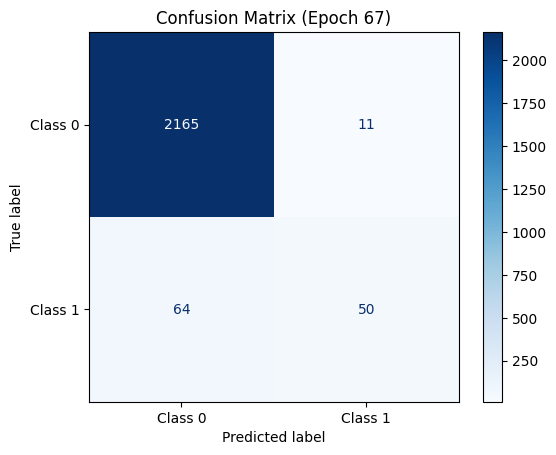

Epoch 68/100, Train Loss: 0.0557, Val Loss: 0.0945, Recall: 48.25%


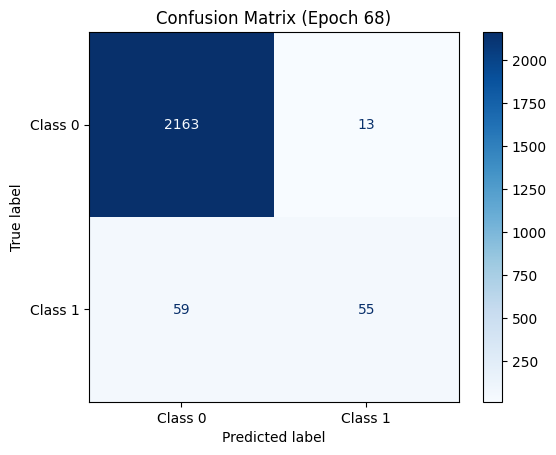

Epoch 69/100, Train Loss: 0.0552, Val Loss: 0.0936, Recall: 48.25%


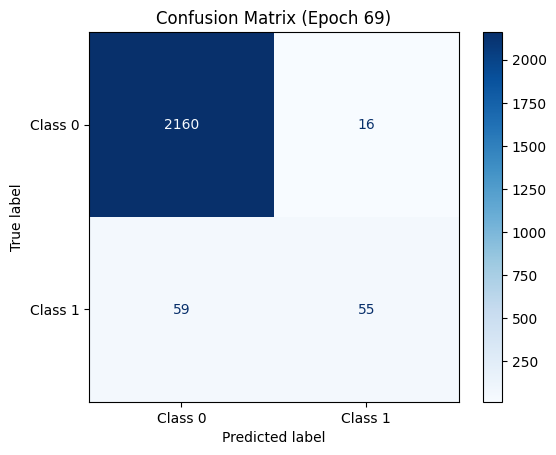

Epoch 70/100, Train Loss: 0.0549, Val Loss: 0.0934, Recall: 48.25%


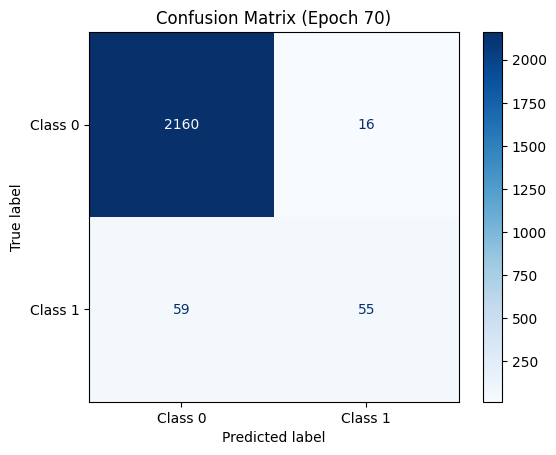

Epoch 71/100, Train Loss: 0.0547, Val Loss: 0.0935, Recall: 51.75%


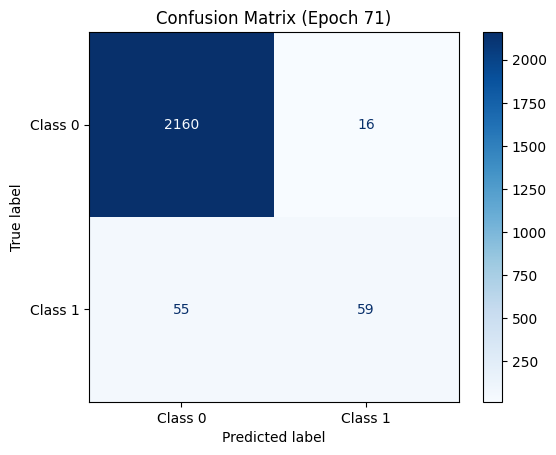

Epoch 72/100, Train Loss: 0.0545, Val Loss: 0.0938, Recall: 49.12%


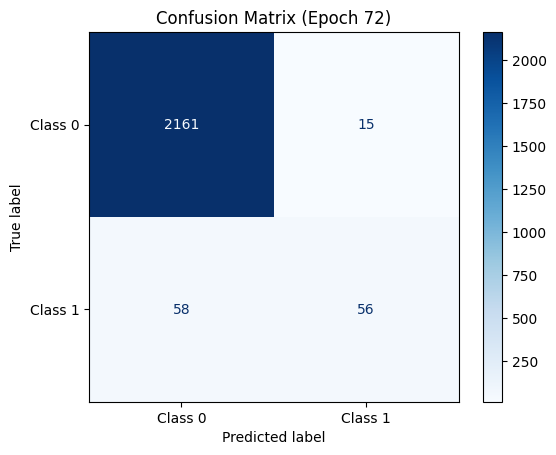

Epoch 73/100, Train Loss: 0.0543, Val Loss: 0.0960, Recall: 45.61%


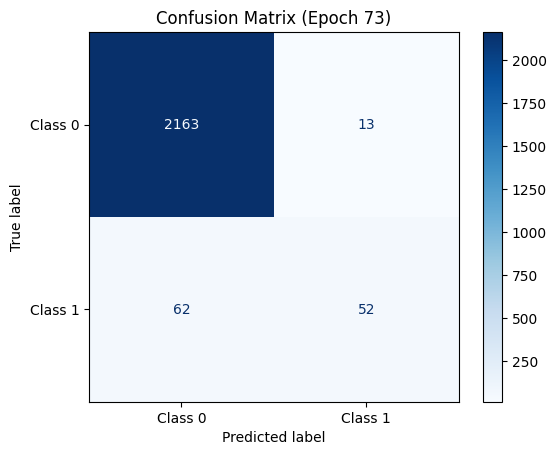

Epoch 74/100, Train Loss: 0.0541, Val Loss: 0.0911, Recall: 55.26%


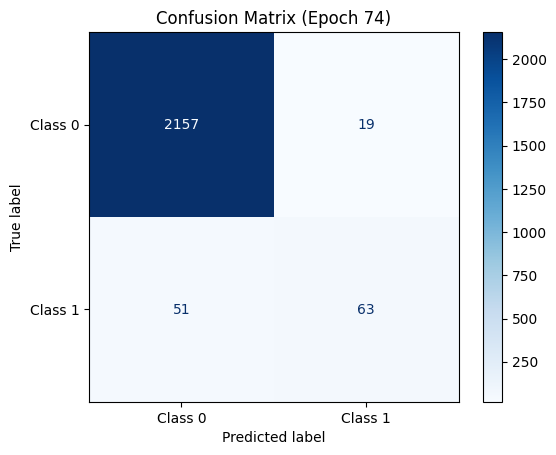

Epoch 75/100, Train Loss: 0.0539, Val Loss: 0.0943, Recall: 52.63%


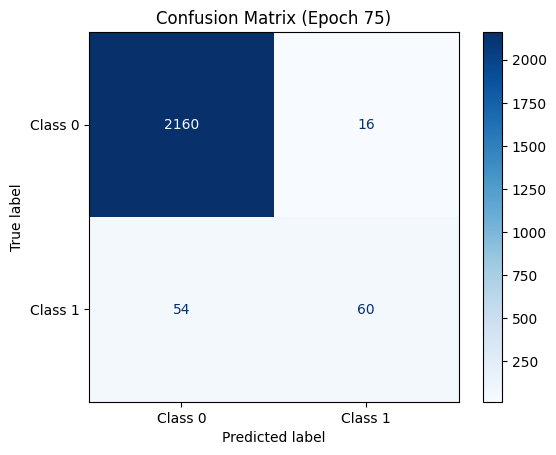

Epoch 76/100, Train Loss: 0.0536, Val Loss: 0.0930, Recall: 52.63%


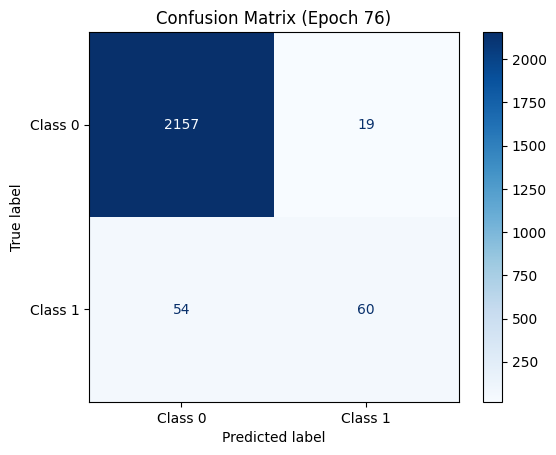

Epoch 77/100, Train Loss: 0.0534, Val Loss: 0.0954, Recall: 50.00%


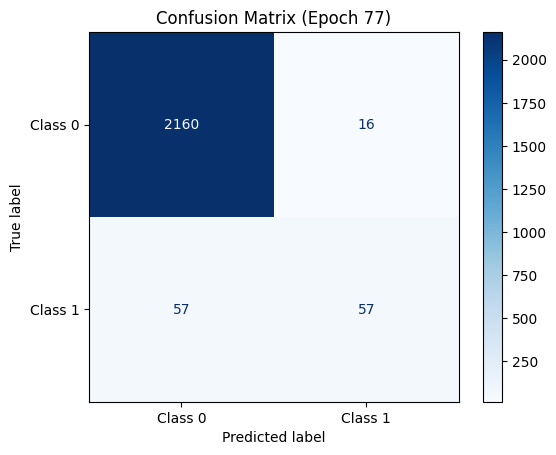

Epoch 78/100, Train Loss: 0.0532, Val Loss: 0.0949, Recall: 50.88%


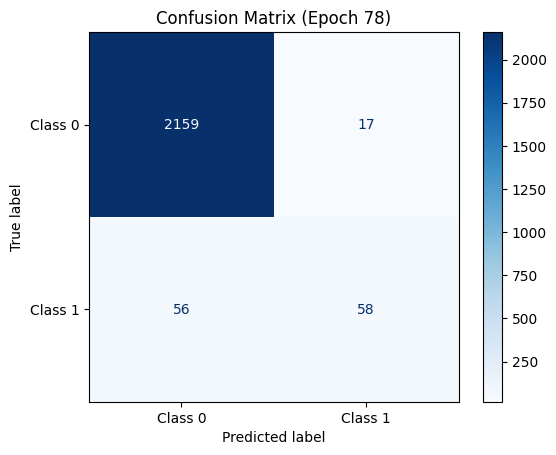

Epoch 79/100, Train Loss: 0.0531, Val Loss: 0.0948, Recall: 52.63%


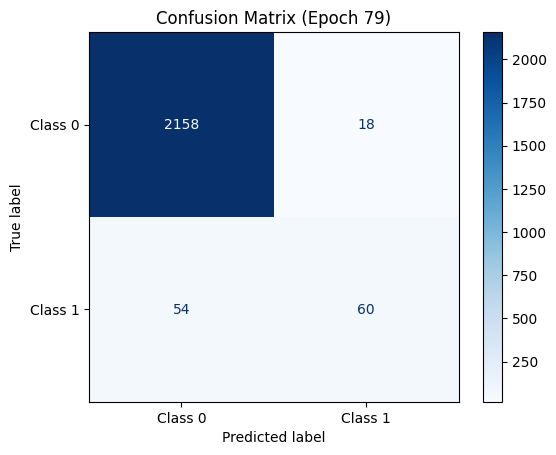

Epoch 80/100, Train Loss: 0.0529, Val Loss: 0.0957, Recall: 49.12%


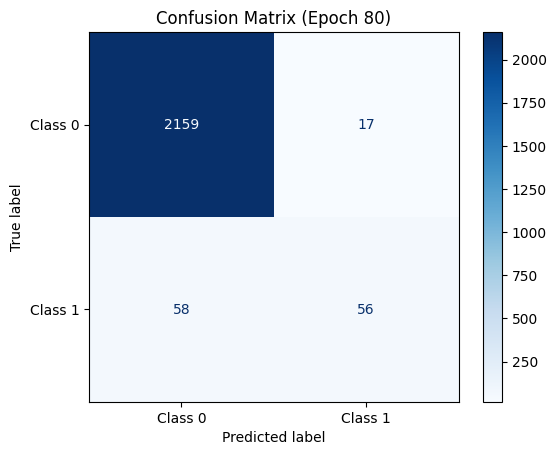

Epoch 81/100, Train Loss: 0.0528, Val Loss: 0.0966, Recall: 46.49%


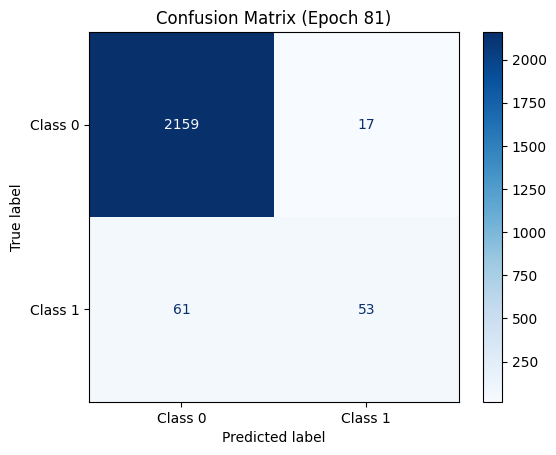

Epoch 82/100, Train Loss: 0.0525, Val Loss: 0.0954, Recall: 52.63%


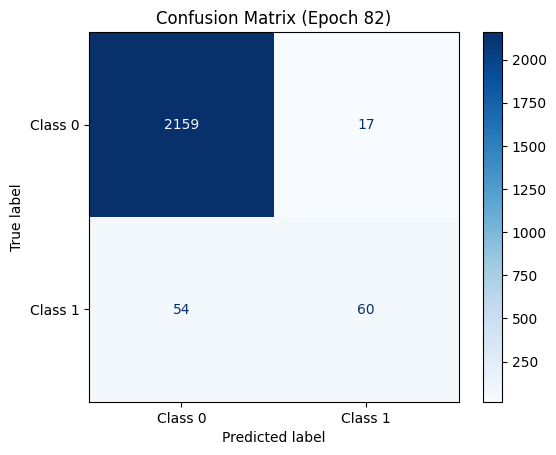

Epoch 83/100, Train Loss: 0.0525, Val Loss: 0.0945, Recall: 53.51%


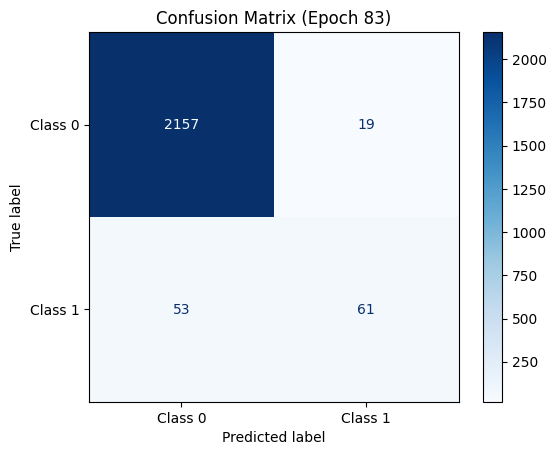

Epoch 84/100, Train Loss: 0.0521, Val Loss: 0.0966, Recall: 50.00%


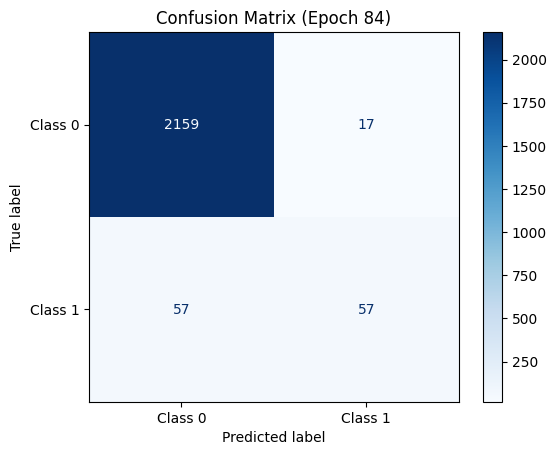

Epoch 85/100, Train Loss: 0.0518, Val Loss: 0.0934, Recall: 54.39%


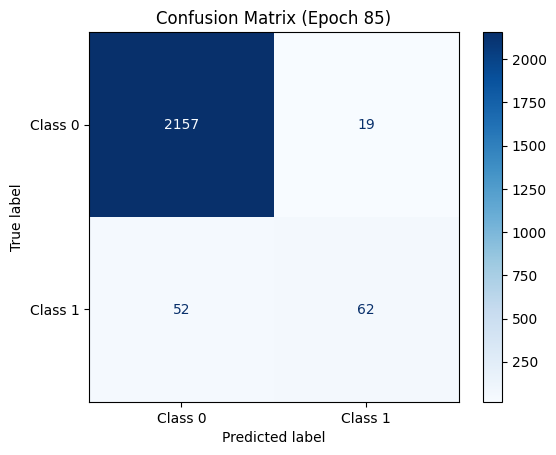

Epoch 86/100, Train Loss: 0.0518, Val Loss: 0.0958, Recall: 53.51%


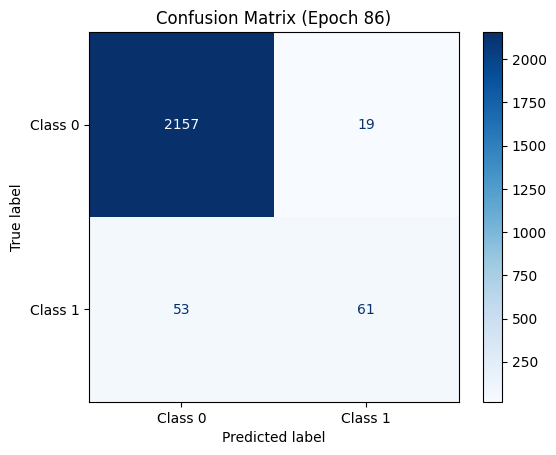

Epoch 87/100, Train Loss: 0.0517, Val Loss: 0.0964, Recall: 51.75%


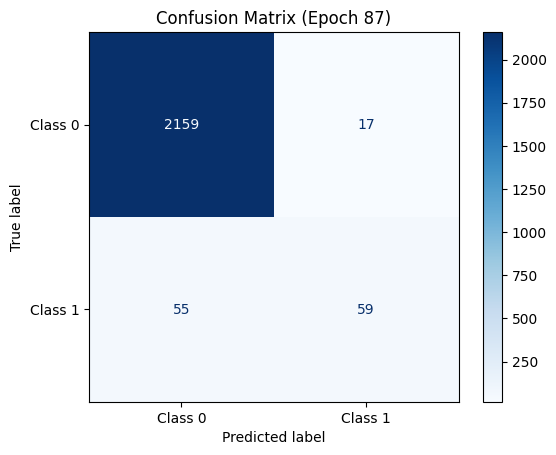

Epoch 88/100, Train Loss: 0.0517, Val Loss: 0.0946, Recall: 53.51%


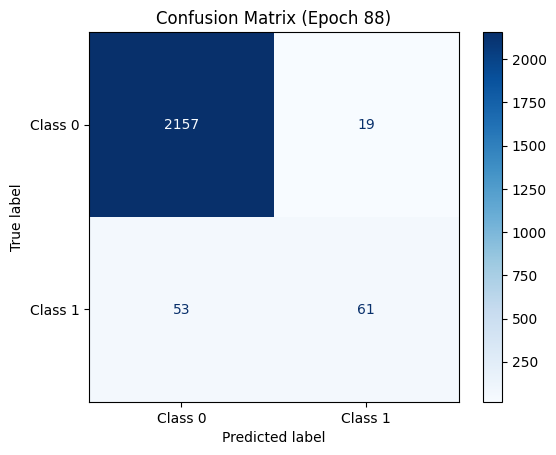

Epoch 89/100, Train Loss: 0.0515, Val Loss: 0.0936, Recall: 54.39%


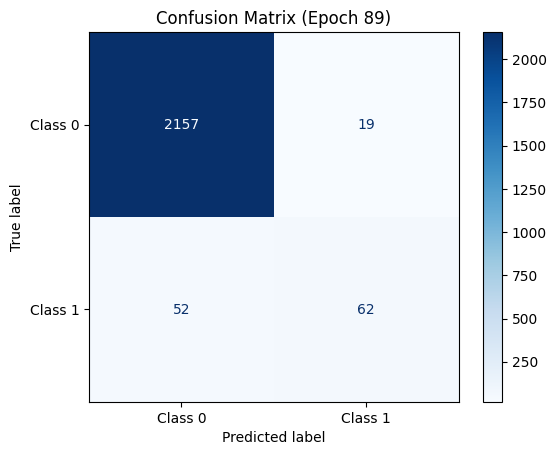

Epoch 90/100, Train Loss: 0.0512, Val Loss: 0.0968, Recall: 51.75%


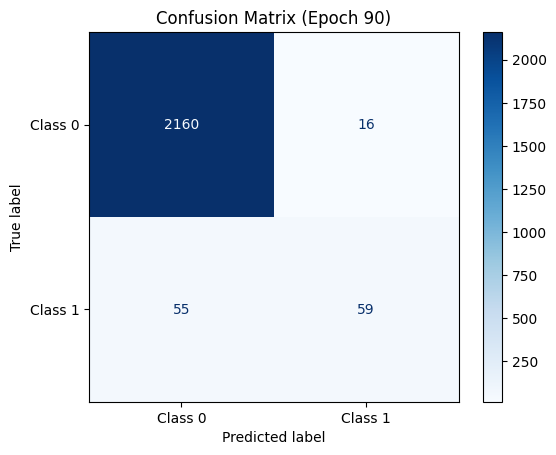

Epoch 91/100, Train Loss: 0.0509, Val Loss: 0.0950, Recall: 53.51%


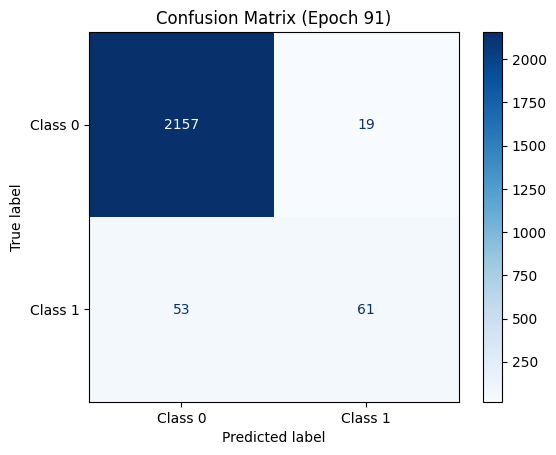

Epoch 92/100, Train Loss: 0.0507, Val Loss: 0.0950, Recall: 54.39%


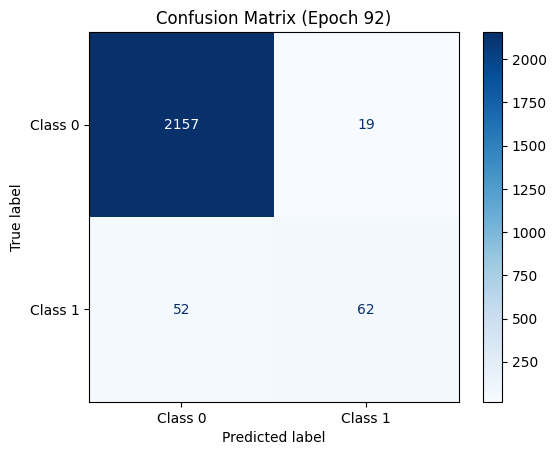

Epoch 93/100, Train Loss: 0.0504, Val Loss: 0.0972, Recall: 52.63%


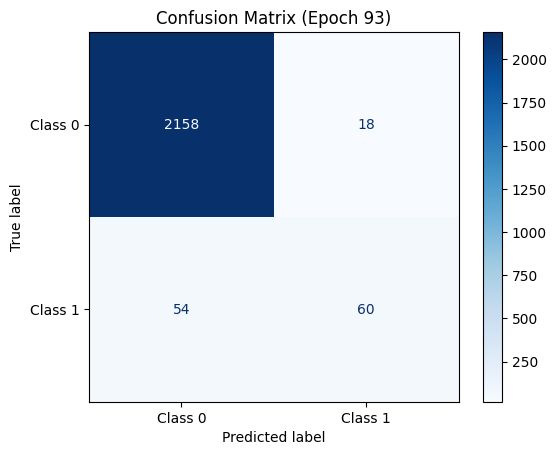

Epoch 94/100, Train Loss: 0.0504, Val Loss: 0.0993, Recall: 47.37%


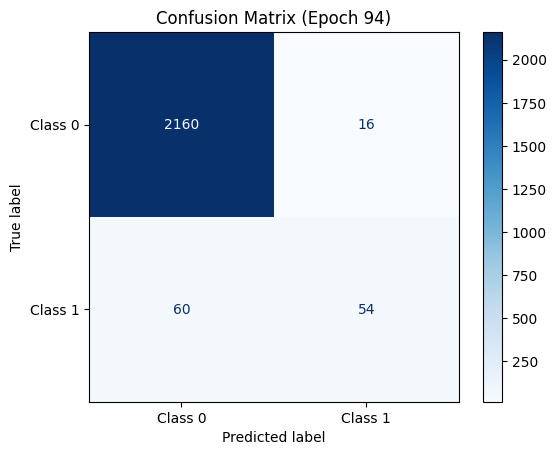

Epoch 95/100, Train Loss: 0.0501, Val Loss: 0.0946, Recall: 54.39%


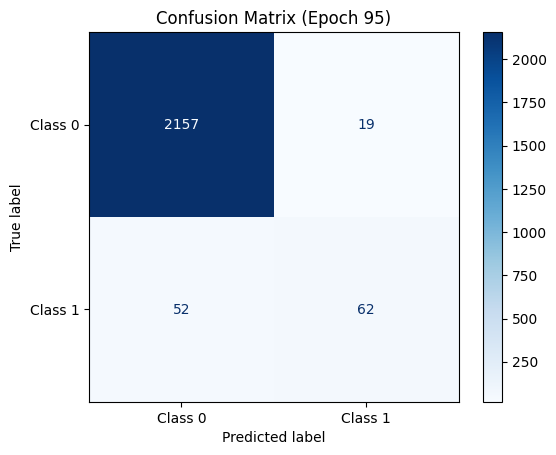

Epoch 96/100, Train Loss: 0.0502, Val Loss: 0.0970, Recall: 54.39%


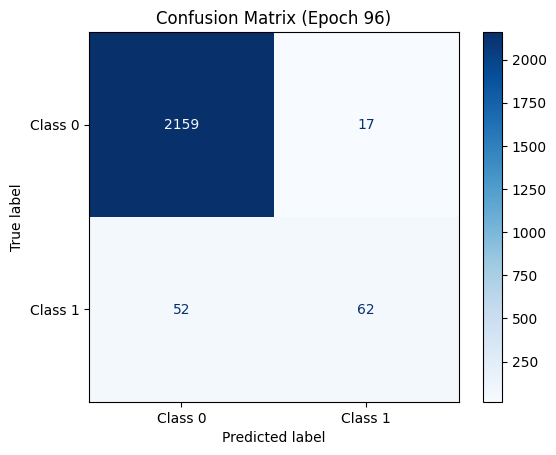

Epoch 97/100, Train Loss: 0.0500, Val Loss: 0.0990, Recall: 48.25%


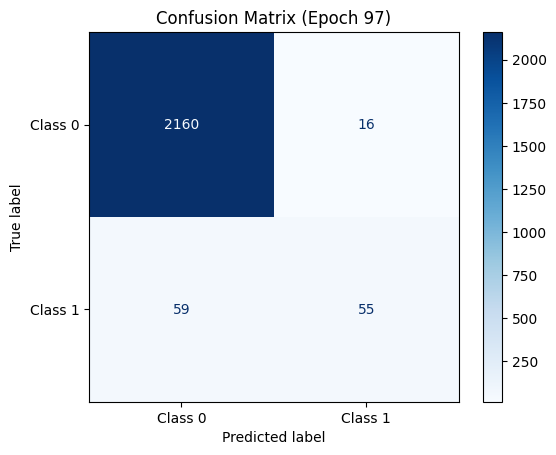

Epoch 98/100, Train Loss: 0.0498, Val Loss: 0.0956, Recall: 54.39%


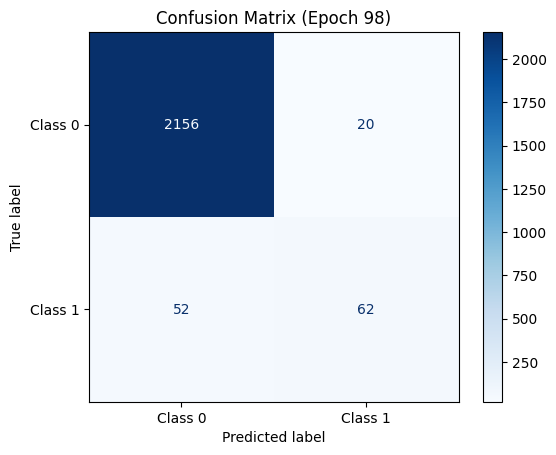

Epoch 99/100, Train Loss: 0.0495, Val Loss: 0.0980, Recall: 51.75%


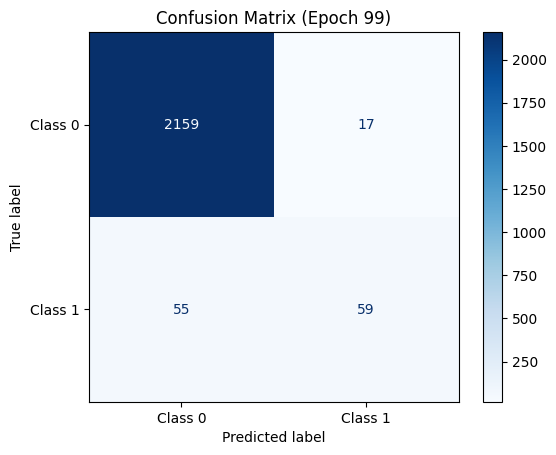

Epoch 100/100, Train Loss: 0.0495, Val Loss: 0.0964, Recall: 54.39%


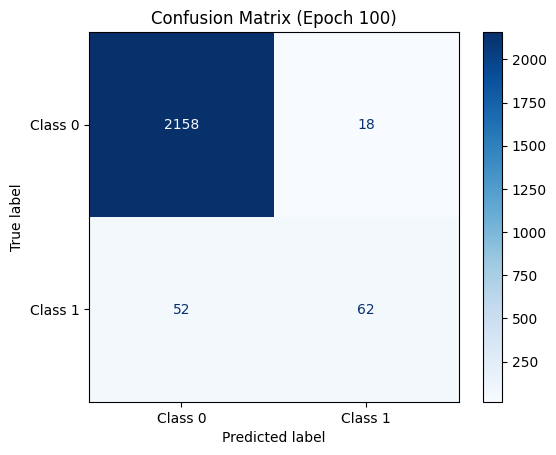

In [16]:
# trying with a simple model
train_model(model, criterion, optimizer, train_data, val_data, 100)

We get a max recall of 42.11 with this simple model. 

In [17]:
class DeepWinnerClassifier(nn.Module):
    def __init__(self, input_size, hidden, output_size):
        super(DeepWinnerClassifier, self).__init__()
        self.hidden1 = nn.Linear(input_size, hidden)  # Hidden layer 1
        self.hidden2 = nn.Linear(hidden, hidden)  # Hidden layer 2
        self.hidden3 = nn.Linear(hidden, hidden)  # Hidden layer 3
        self.hidden4 = nn.Linear(hidden, hidden)  # Hidden layer 4
        self.hidden5 = nn.Linear(hidden, hidden)  # Hidden layer 5
        self.output = nn.Linear(hidden, output_size)  # Output layer
        self.relu = nn.ReLU()  # Activation function
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.relu(self.hidden3(x))
        x = self.relu(self.hidden4(x))
        x = self.relu(self.hidden5(x))
        x = self.output(x)
        return self.sigmoid(x)

In [18]:
model = DeepWinnerClassifier(input_size, hidden, output_size)
model.to(device)

DeepWinnerClassifier(
  (hidden1): Linear(in_features=22, out_features=44, bias=True)
  (hidden2): Linear(in_features=44, out_features=44, bias=True)
  (hidden3): Linear(in_features=44, out_features=44, bias=True)
  (hidden4): Linear(in_features=44, out_features=44, bias=True)
  (hidden5): Linear(in_features=44, out_features=44, bias=True)
  (output): Linear(in_features=44, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [19]:
train_data, val_data = prepare_data(X_train, X_val, y_train, y_val)

Epoch 1/100, Train Loss: 0.1827, Val Loss: 0.0958, Recall: 0.00%


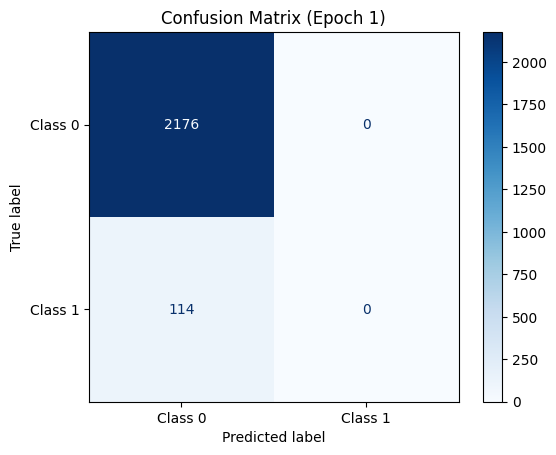

Epoch 2/100, Train Loss: 0.0812, Val Loss: 0.1089, Recall: 35.96%


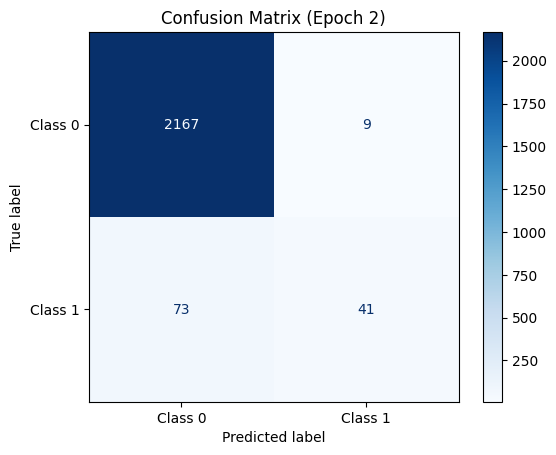

Epoch 3/100, Train Loss: 0.0731, Val Loss: 0.0927, Recall: 51.75%


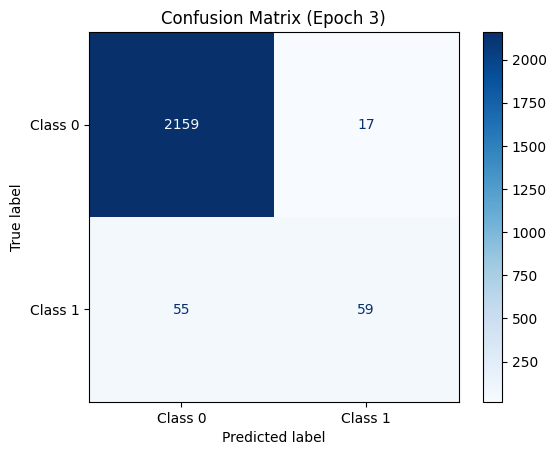

Epoch 4/100, Train Loss: 0.0675, Val Loss: 0.1006, Recall: 28.07%


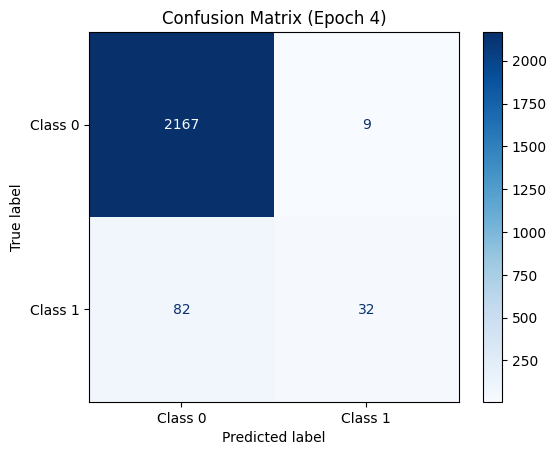

Epoch 5/100, Train Loss: 0.0644, Val Loss: 0.0839, Recall: 52.63%


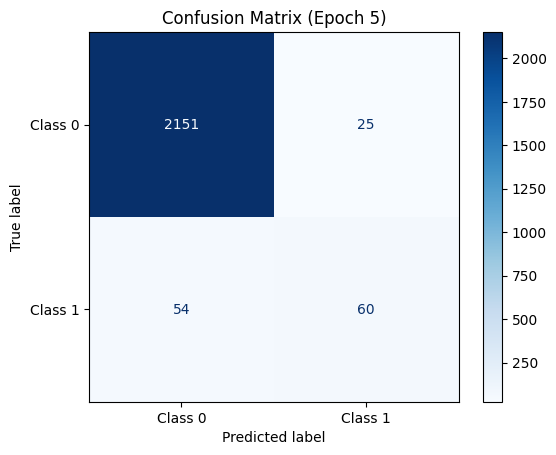

Epoch 6/100, Train Loss: 0.0627, Val Loss: 0.1215, Recall: 50.88%


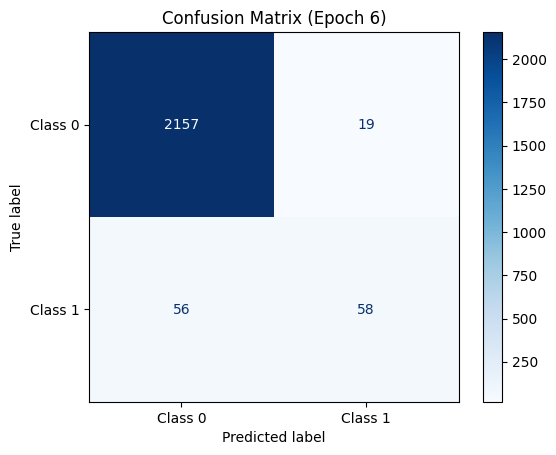

Epoch 7/100, Train Loss: 0.0602, Val Loss: 0.0989, Recall: 54.39%


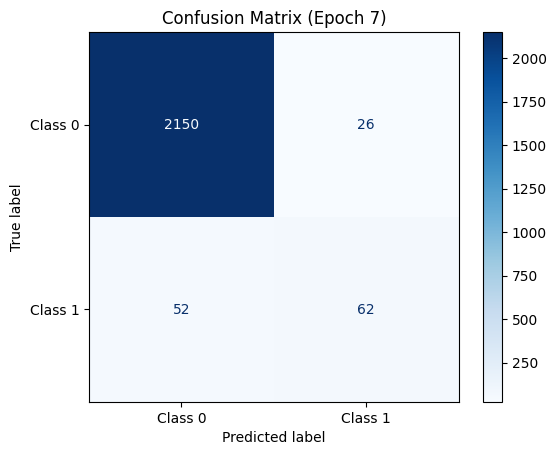

Epoch 8/100, Train Loss: 0.0571, Val Loss: 0.0861, Recall: 72.81%


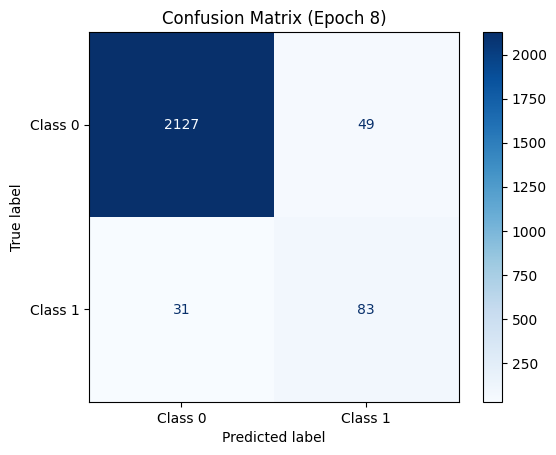

Epoch 9/100, Train Loss: 0.0560, Val Loss: 0.1066, Recall: 55.26%


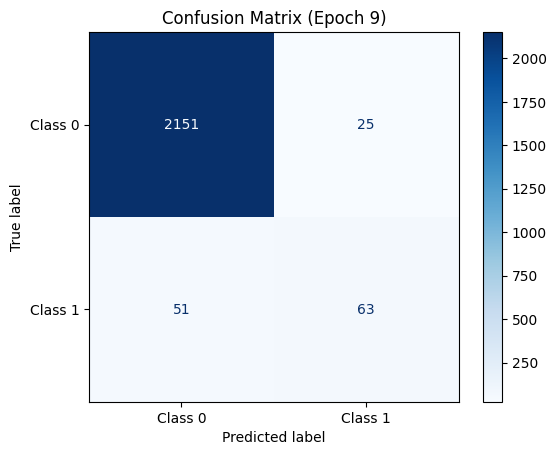

Epoch 10/100, Train Loss: 0.0549, Val Loss: 0.1013, Recall: 68.42%


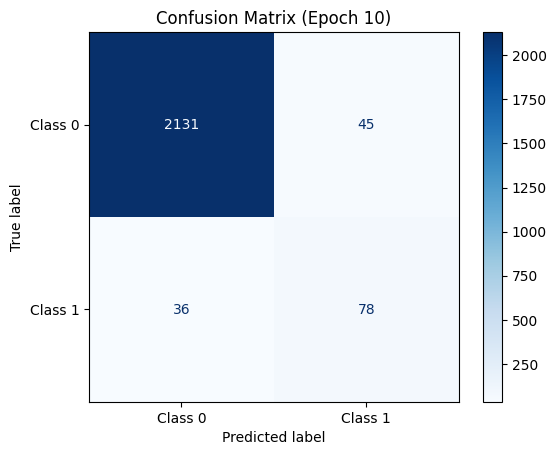

Epoch 11/100, Train Loss: 0.0508, Val Loss: 0.1013, Recall: 66.67%


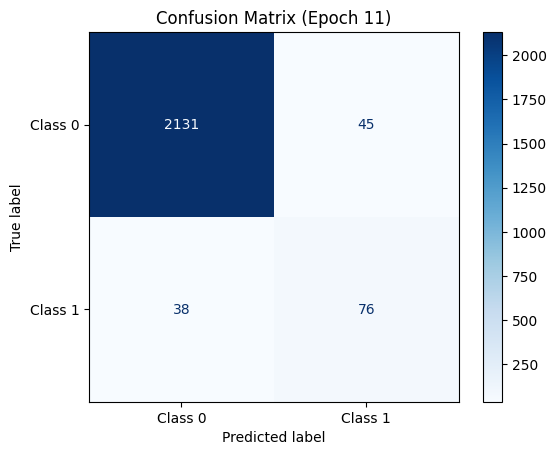

Epoch 12/100, Train Loss: 0.0497, Val Loss: 0.1405, Recall: 65.79%


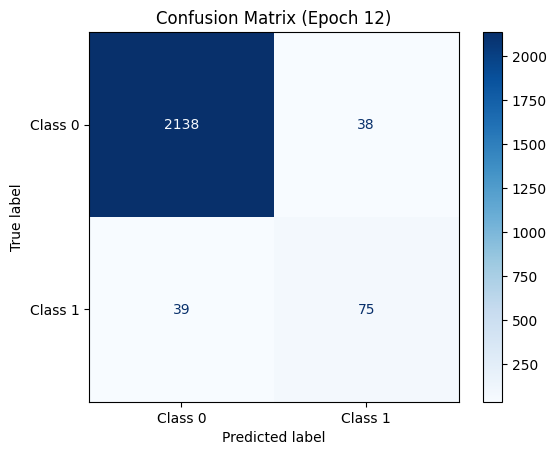

Epoch 13/100, Train Loss: 0.0493, Val Loss: 0.1061, Recall: 70.18%


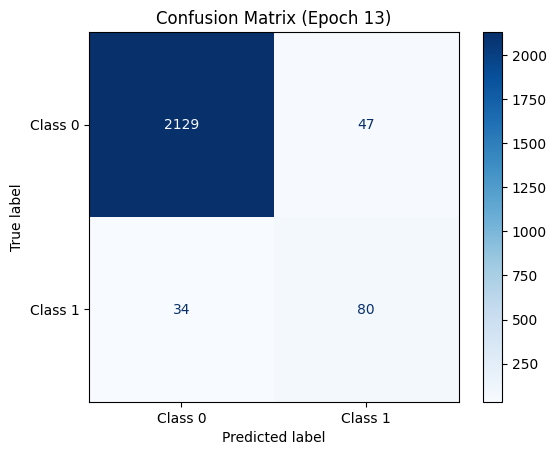

Epoch 14/100, Train Loss: 0.0472, Val Loss: 0.1587, Recall: 65.79%


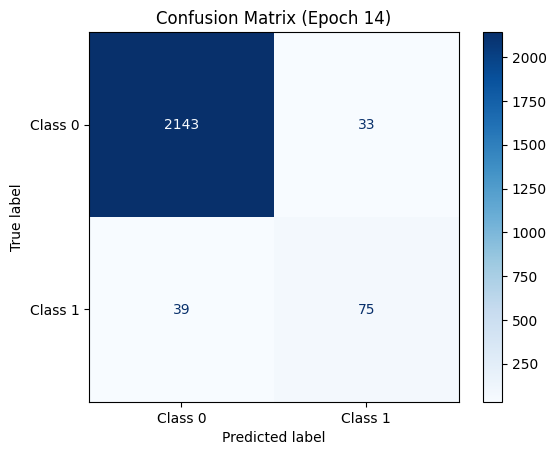

Epoch 15/100, Train Loss: 0.0454, Val Loss: 0.2085, Recall: 52.63%


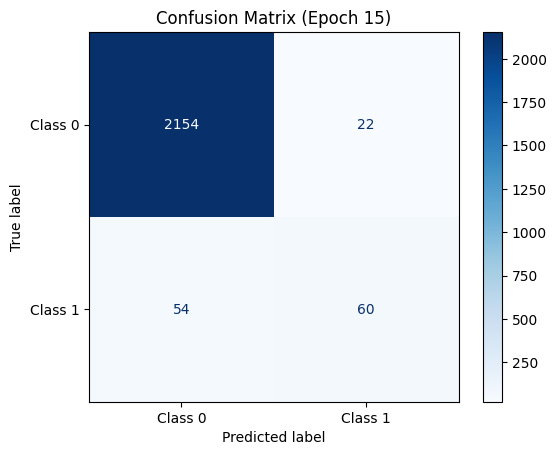

Epoch 16/100, Train Loss: 0.0435, Val Loss: 0.2521, Recall: 61.40%


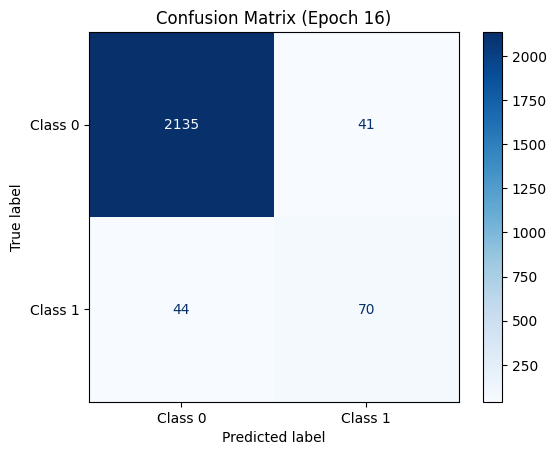

Epoch 17/100, Train Loss: 0.0454, Val Loss: 0.2347, Recall: 55.26%


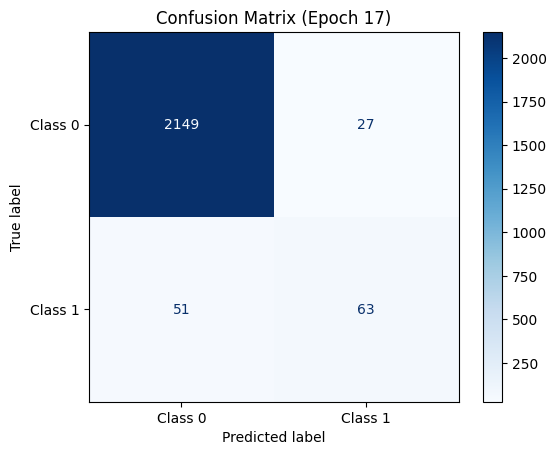

Epoch 18/100, Train Loss: 0.0423, Val Loss: 0.2916, Recall: 50.00%


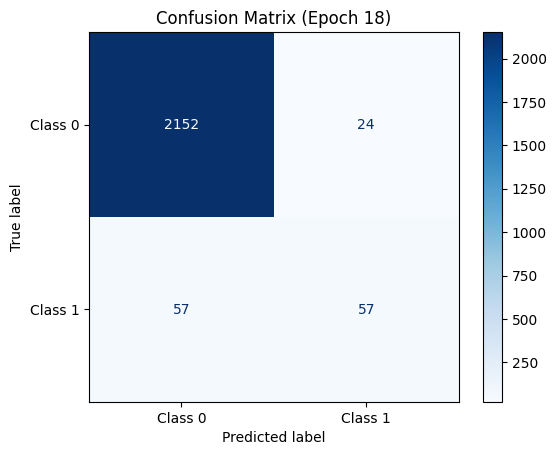

Epoch 19/100, Train Loss: 0.0415, Val Loss: 0.1856, Recall: 72.81%


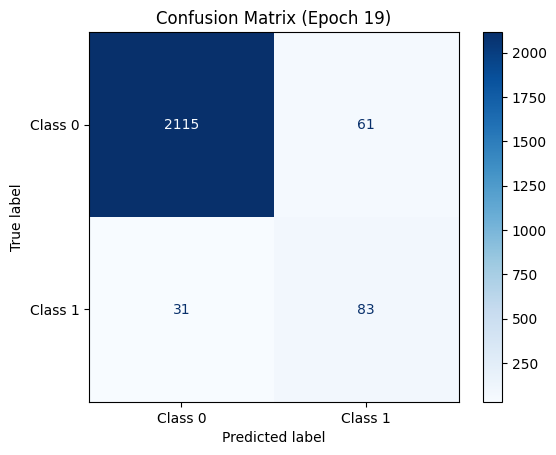

Epoch 20/100, Train Loss: 0.0404, Val Loss: 0.2095, Recall: 60.53%


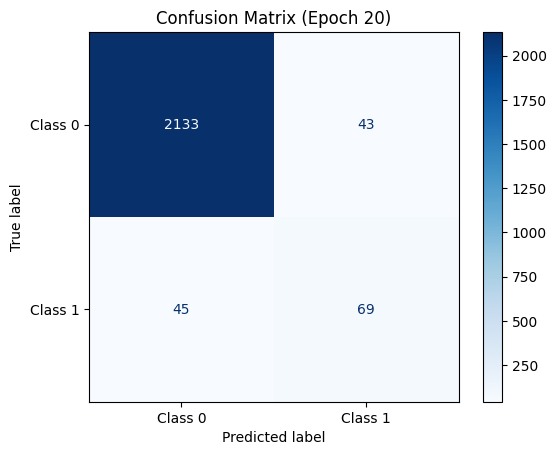

Epoch 21/100, Train Loss: 0.0396, Val Loss: 0.2714, Recall: 44.74%


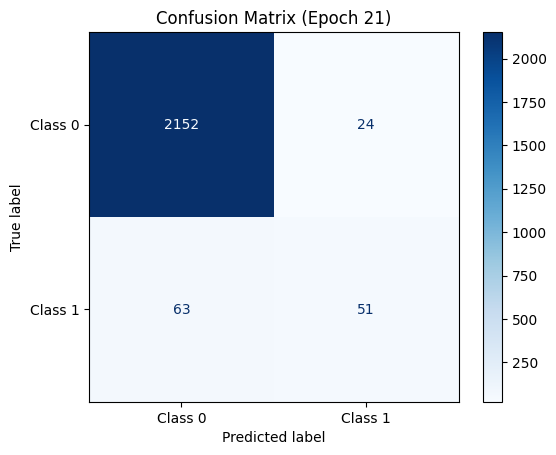

Epoch 22/100, Train Loss: 0.0381, Val Loss: 0.2274, Recall: 56.14%


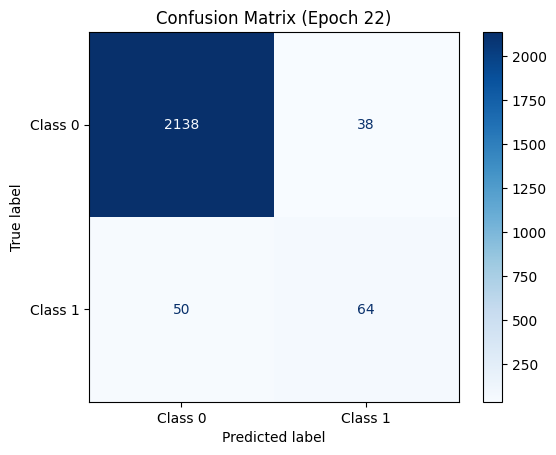

Epoch 23/100, Train Loss: 0.0379, Val Loss: 0.1874, Recall: 69.30%


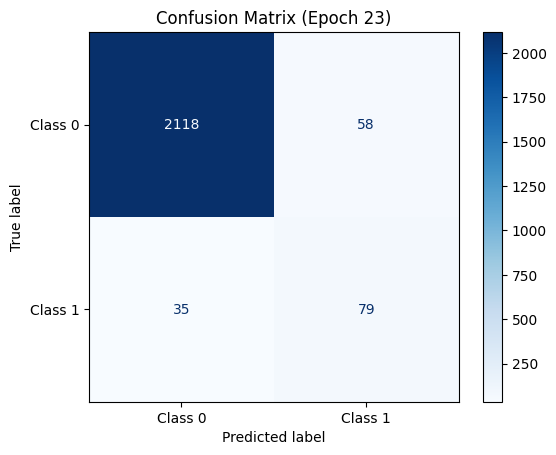

Epoch 24/100, Train Loss: 0.0390, Val Loss: 0.2516, Recall: 50.88%


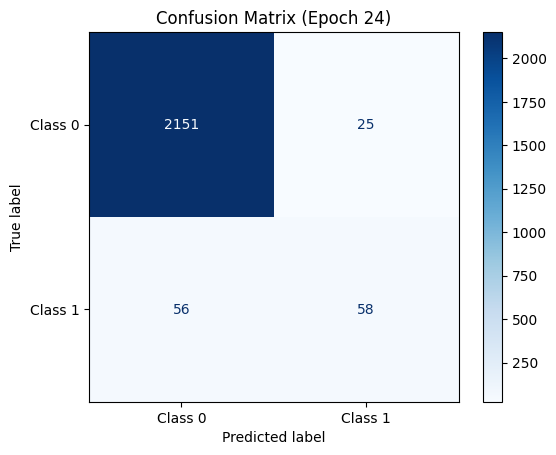

Epoch 25/100, Train Loss: 0.0359, Val Loss: 0.2383, Recall: 56.14%


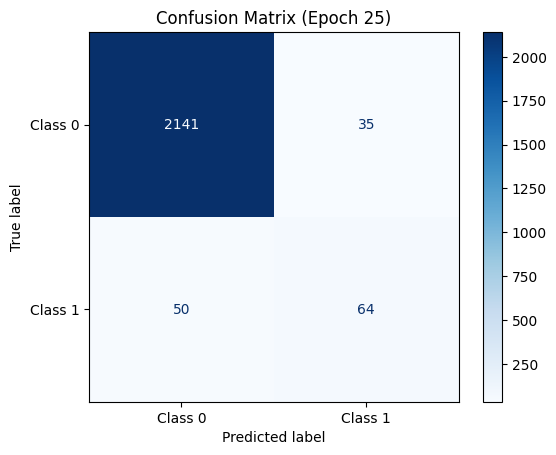

Epoch 26/100, Train Loss: 0.0348, Val Loss: 0.3030, Recall: 64.91%


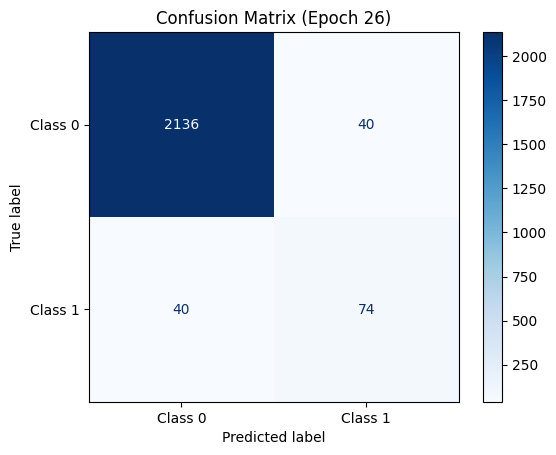

Epoch 27/100, Train Loss: 0.0345, Val Loss: 0.2337, Recall: 66.67%


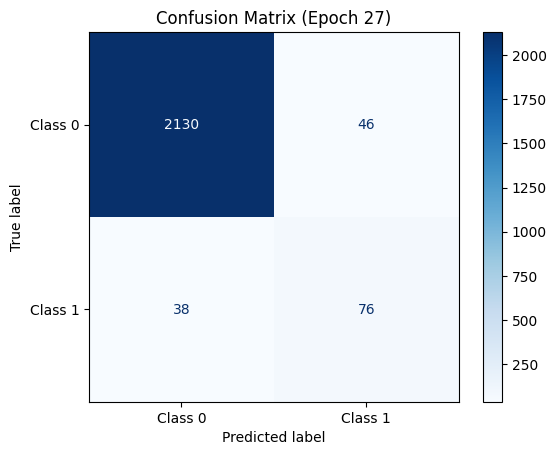

Epoch 28/100, Train Loss: 0.0315, Val Loss: 0.3395, Recall: 54.39%


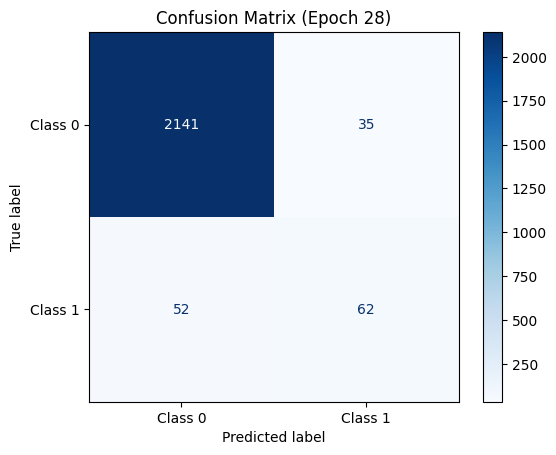

Epoch 29/100, Train Loss: 0.0341, Val Loss: 0.2129, Recall: 64.04%


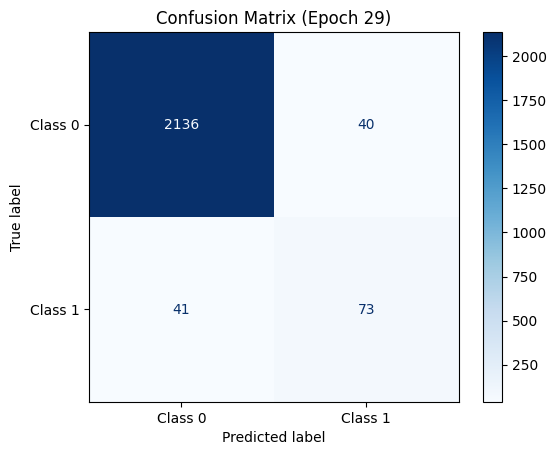

Epoch 30/100, Train Loss: 0.0337, Val Loss: 0.2534, Recall: 60.53%


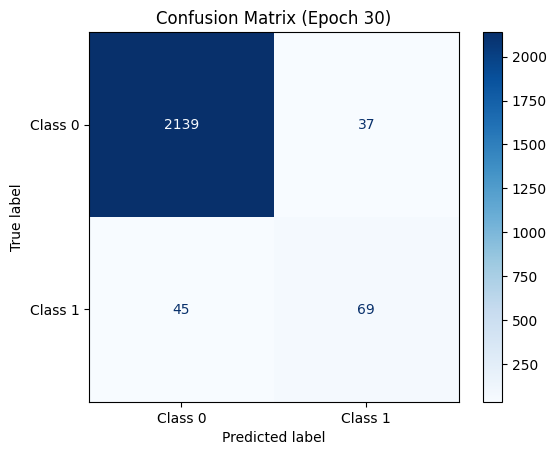

Epoch 31/100, Train Loss: 0.0290, Val Loss: 0.3828, Recall: 52.63%


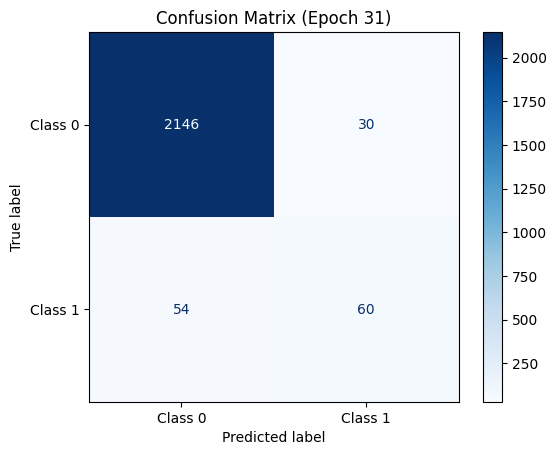

Epoch 32/100, Train Loss: 0.0325, Val Loss: 0.4275, Recall: 56.14%


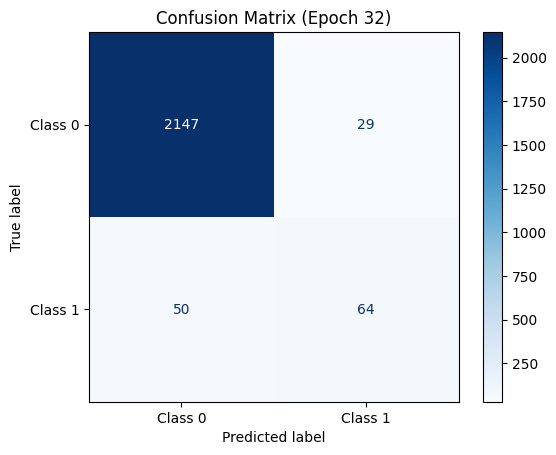

Epoch 33/100, Train Loss: 0.0311, Val Loss: 0.3048, Recall: 60.53%


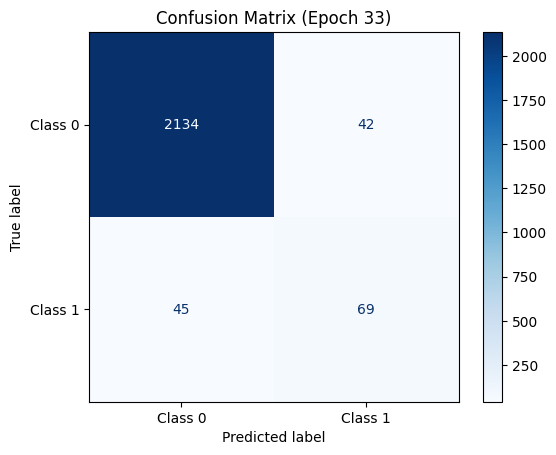

Epoch 34/100, Train Loss: 0.0303, Val Loss: 0.3106, Recall: 65.79%


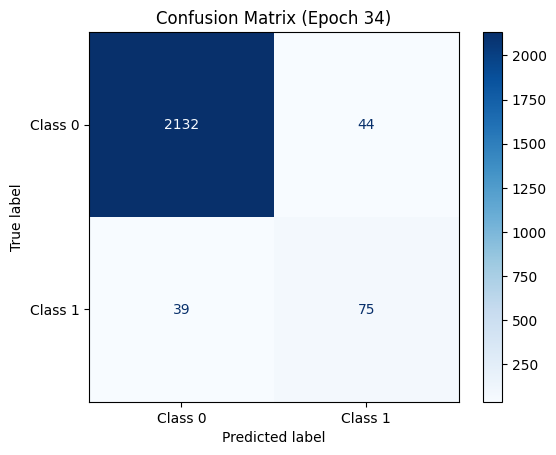

Epoch 35/100, Train Loss: 0.0315, Val Loss: 0.3261, Recall: 60.53%


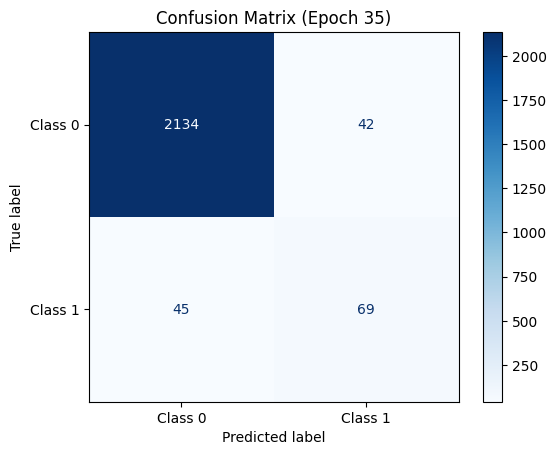

Epoch 36/100, Train Loss: 0.0277, Val Loss: 0.3343, Recall: 58.77%


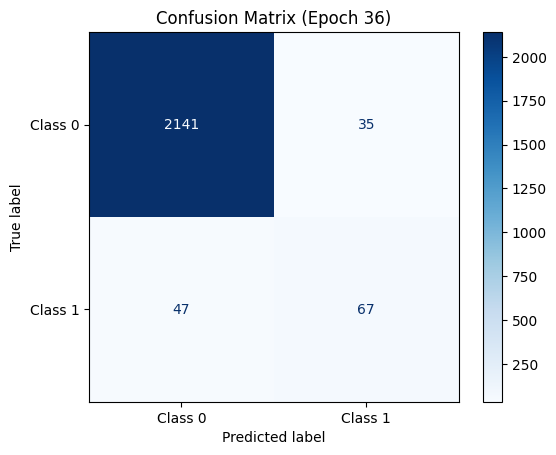

Epoch 37/100, Train Loss: 0.0261, Val Loss: 0.4335, Recall: 45.61%


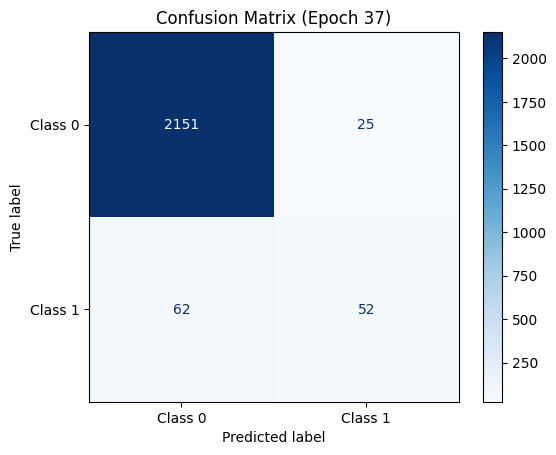

Epoch 38/100, Train Loss: 0.0288, Val Loss: 0.4958, Recall: 50.00%


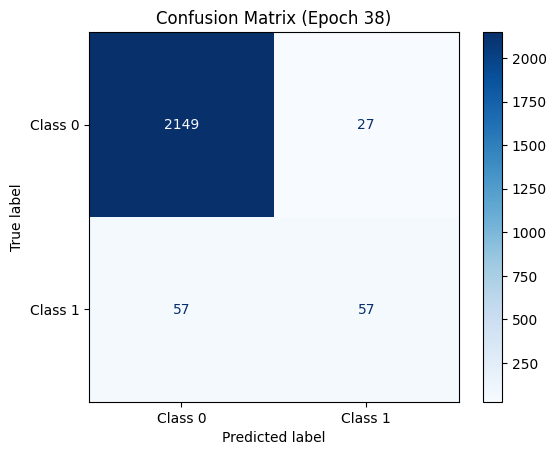

Epoch 39/100, Train Loss: 0.0255, Val Loss: 0.3747, Recall: 61.40%


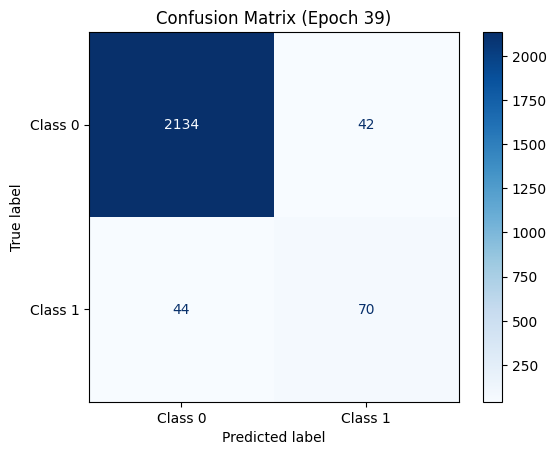

Epoch 40/100, Train Loss: 0.0257, Val Loss: 0.4322, Recall: 64.91%


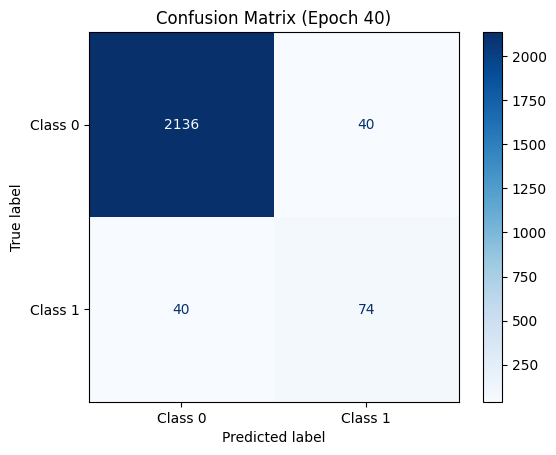

Epoch 41/100, Train Loss: 0.0239, Val Loss: 0.5611, Recall: 51.75%


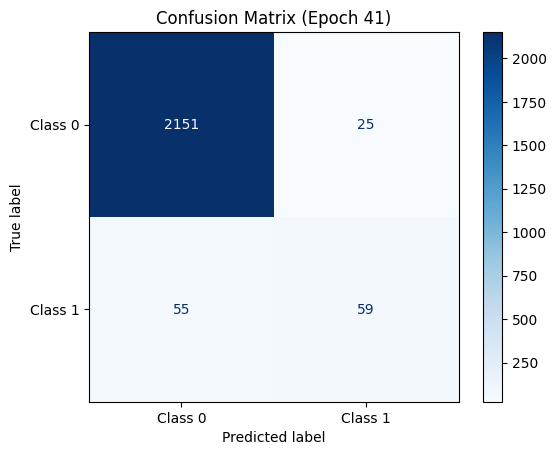

Epoch 42/100, Train Loss: 0.0276, Val Loss: 0.3420, Recall: 50.00%


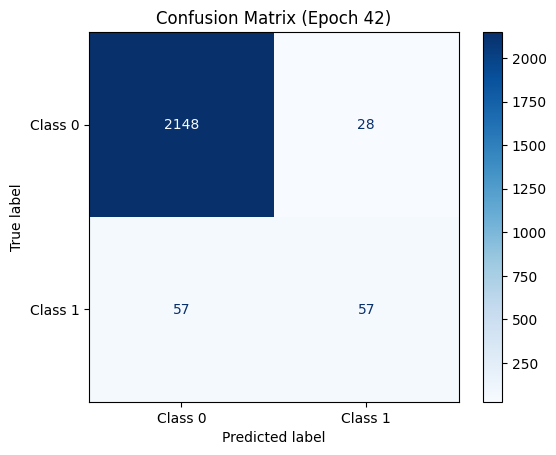

Epoch 43/100, Train Loss: 0.0253, Val Loss: 0.4117, Recall: 62.28%


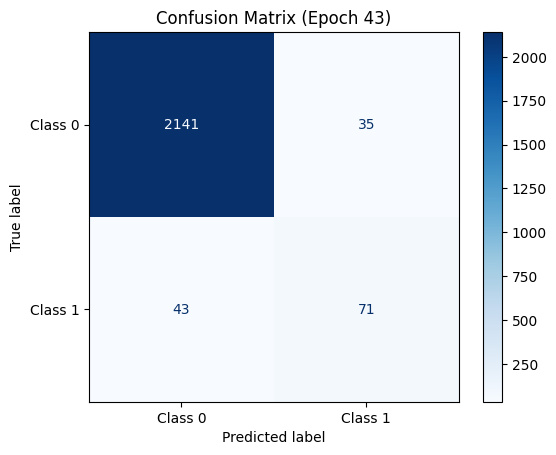

Epoch 44/100, Train Loss: 0.0222, Val Loss: 0.4830, Recall: 63.16%


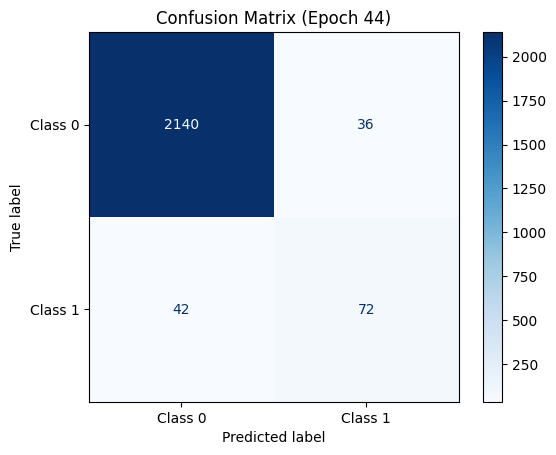

Epoch 45/100, Train Loss: 0.0216, Val Loss: 0.5630, Recall: 54.39%


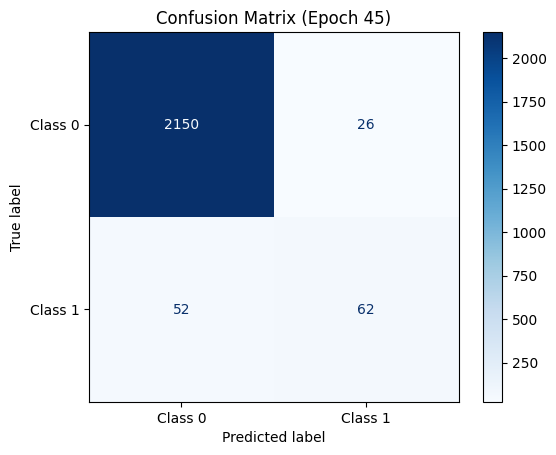

Epoch 46/100, Train Loss: 0.0217, Val Loss: 0.4967, Recall: 57.02%


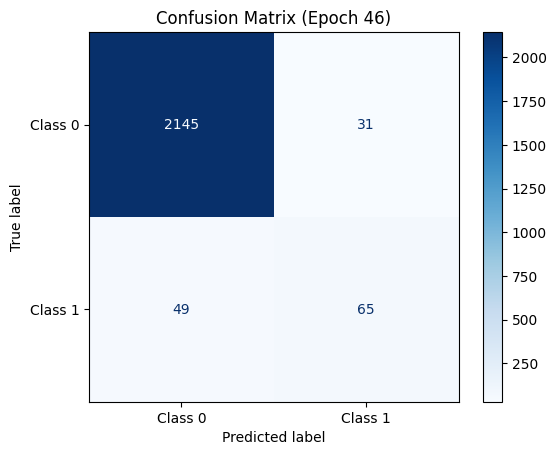

Epoch 47/100, Train Loss: 0.0230, Val Loss: 0.5235, Recall: 50.00%


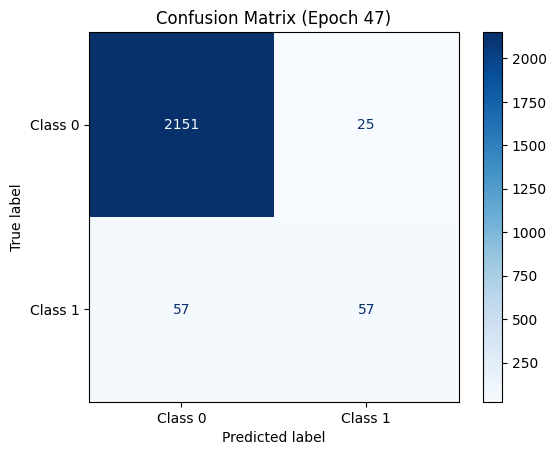

Epoch 48/100, Train Loss: 0.0262, Val Loss: 0.3671, Recall: 57.02%


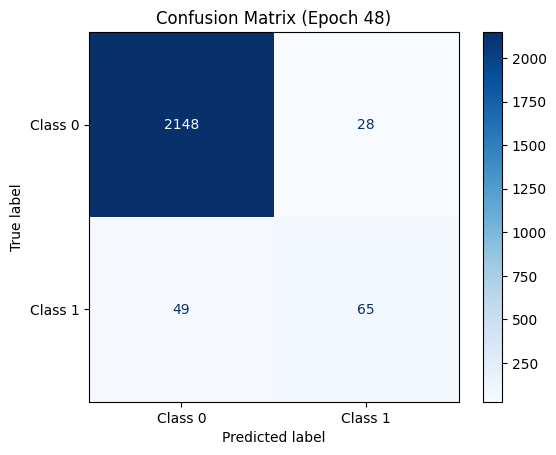

Epoch 49/100, Train Loss: 0.0206, Val Loss: 0.3904, Recall: 73.68%


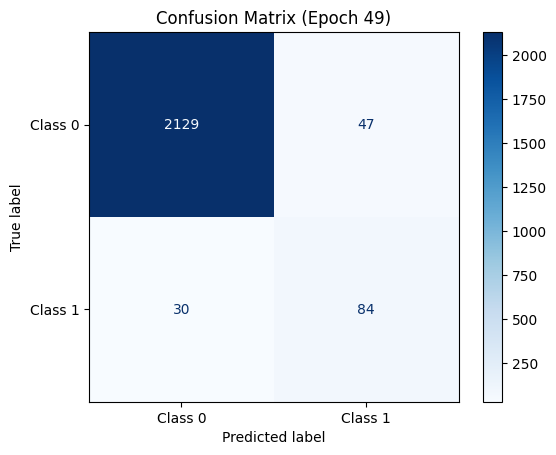

Epoch 50/100, Train Loss: 0.0179, Val Loss: 0.4669, Recall: 59.65%


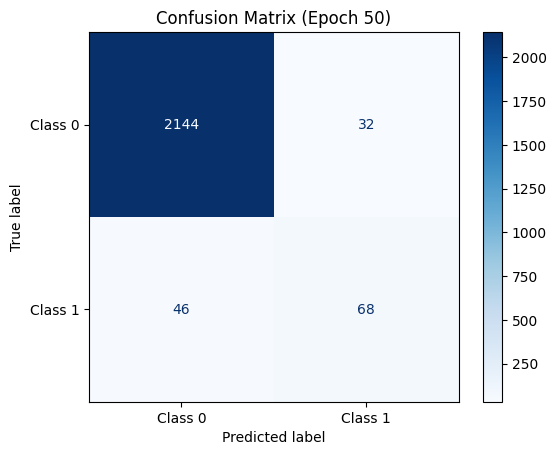

Epoch 51/100, Train Loss: 0.0245, Val Loss: 0.4231, Recall: 51.75%


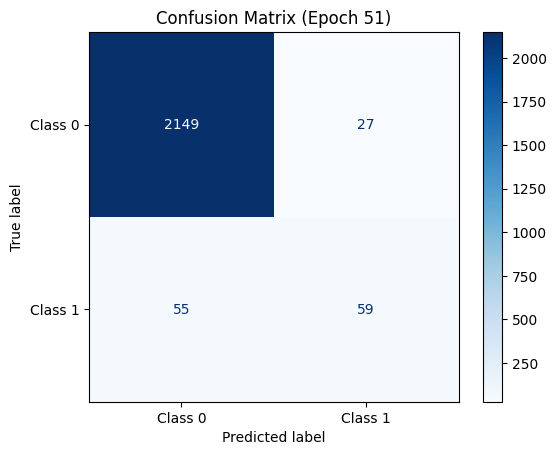

Epoch 52/100, Train Loss: 0.0232, Val Loss: 0.3784, Recall: 56.14%


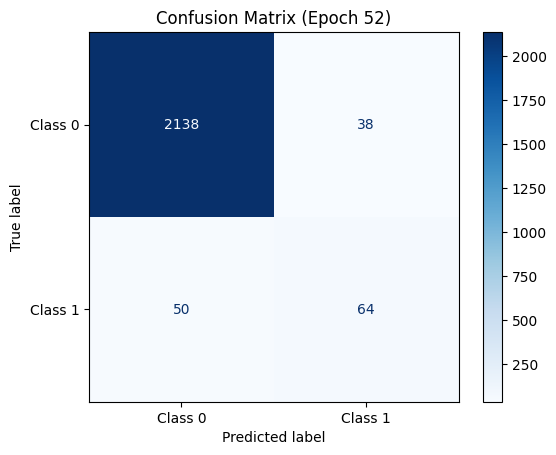

Epoch 53/100, Train Loss: 0.0191, Val Loss: 0.3954, Recall: 62.28%


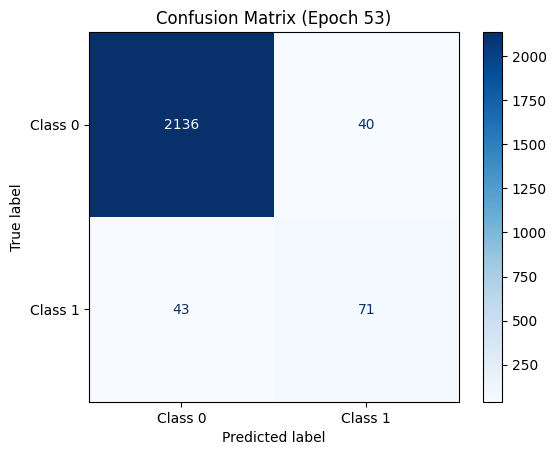

Epoch 54/100, Train Loss: 0.0228, Val Loss: 0.4406, Recall: 57.89%


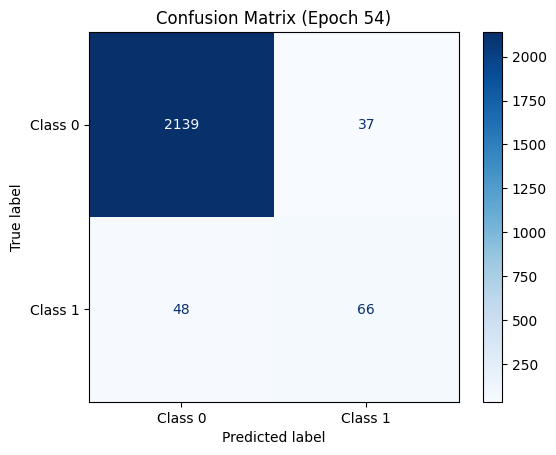

Epoch 55/100, Train Loss: 0.0156, Val Loss: 0.4835, Recall: 57.02%


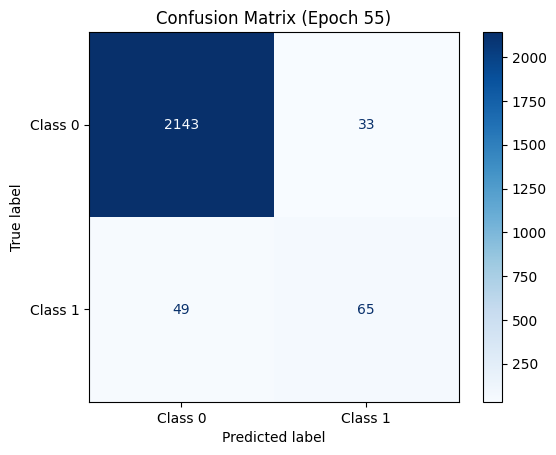

Epoch 56/100, Train Loss: 0.0162, Val Loss: 0.4532, Recall: 58.77%


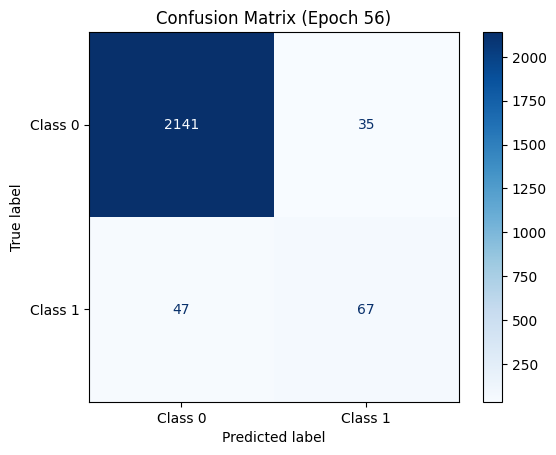

Epoch 57/100, Train Loss: 0.0156, Val Loss: 0.6072, Recall: 51.75%


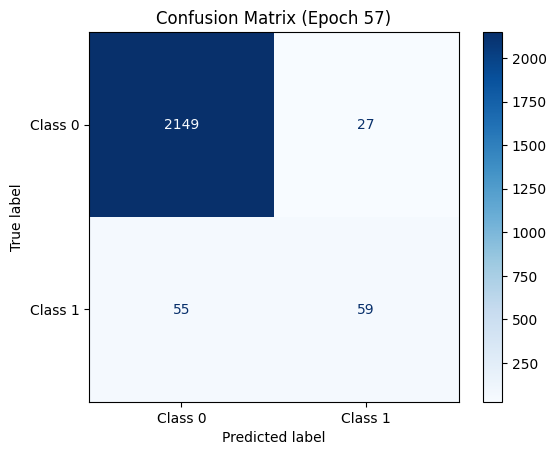

Epoch 58/100, Train Loss: 0.0243, Val Loss: 0.3250, Recall: 64.91%


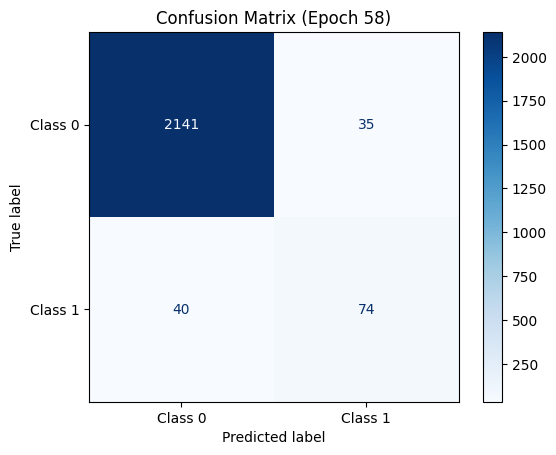

Epoch 59/100, Train Loss: 0.0210, Val Loss: 0.3154, Recall: 65.79%


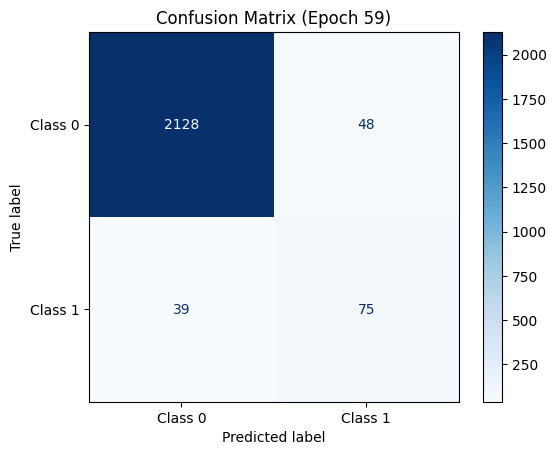

Epoch 60/100, Train Loss: 0.0185, Val Loss: 0.4128, Recall: 52.63%


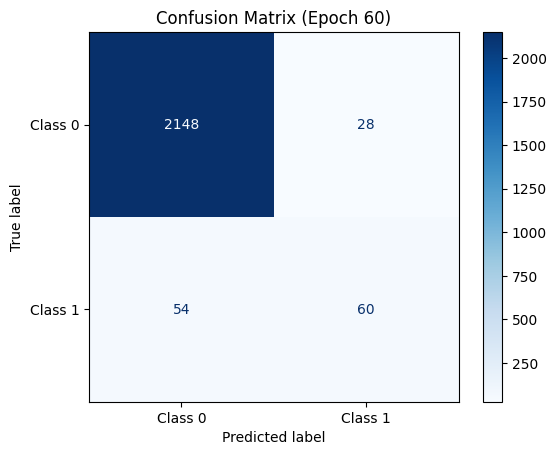

Epoch 61/100, Train Loss: 0.0146, Val Loss: 0.4047, Recall: 57.89%


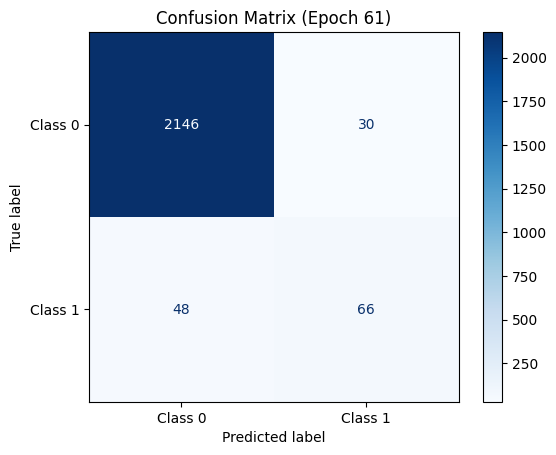

Epoch 62/100, Train Loss: 0.0145, Val Loss: 0.4575, Recall: 57.02%


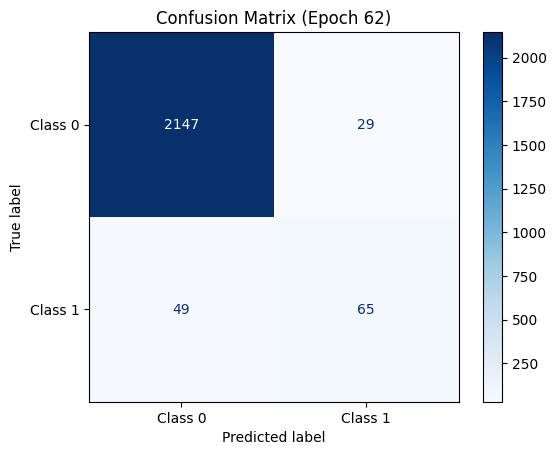

Epoch 63/100, Train Loss: 0.0137, Val Loss: 0.5454, Recall: 57.89%


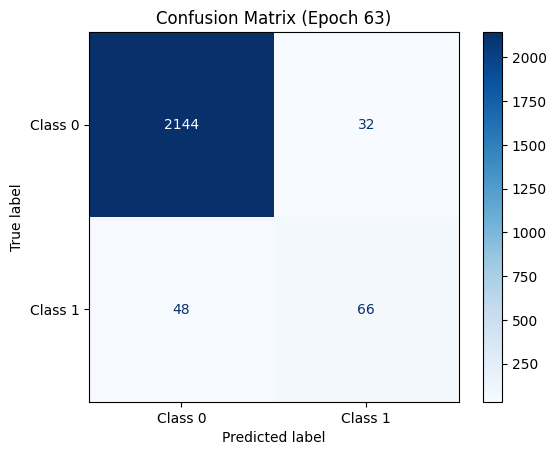

Epoch 64/100, Train Loss: 0.0181, Val Loss: 0.3844, Recall: 51.75%


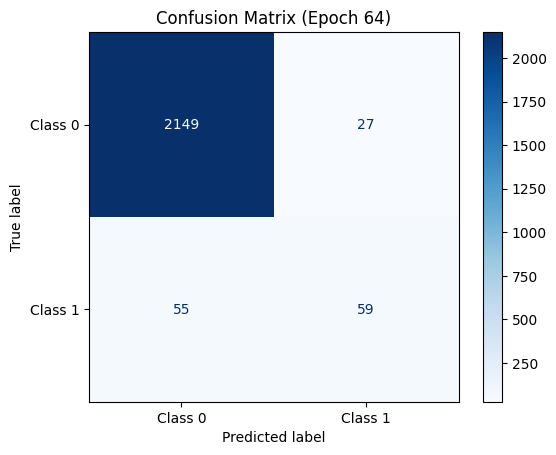

Epoch 65/100, Train Loss: 0.0133, Val Loss: 0.5440, Recall: 45.61%


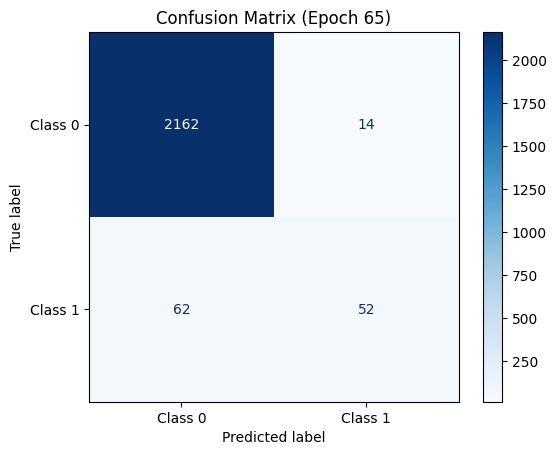

Epoch 66/100, Train Loss: 0.0201, Val Loss: 0.3327, Recall: 57.02%


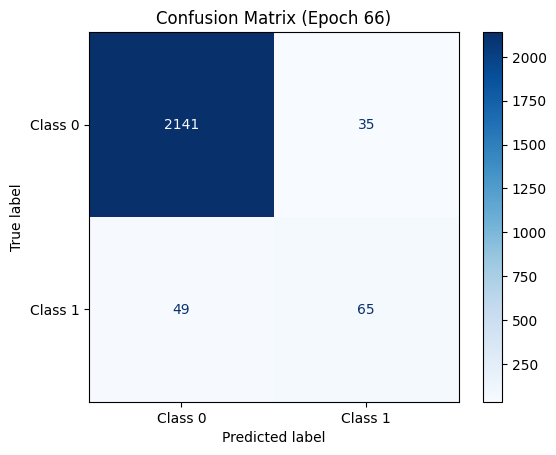

Epoch 67/100, Train Loss: 0.0143, Val Loss: 0.4560, Recall: 53.51%


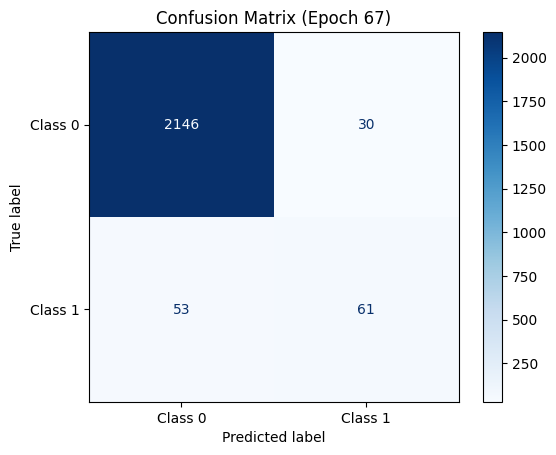

Epoch 68/100, Train Loss: 0.0191, Val Loss: 0.3741, Recall: 52.63%


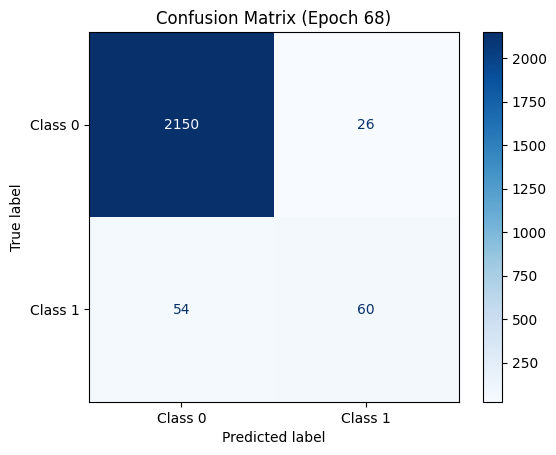

Epoch 69/100, Train Loss: 0.0201, Val Loss: 0.3007, Recall: 56.14%


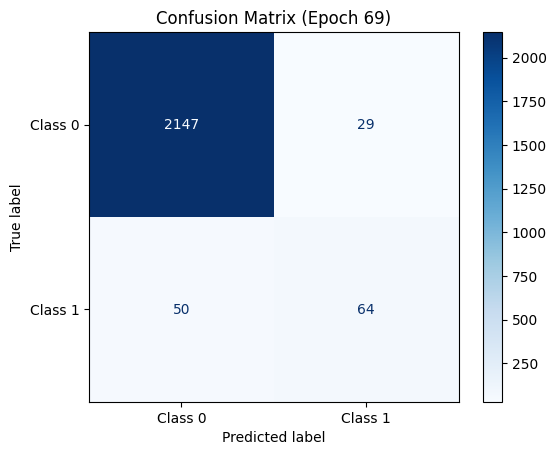

Epoch 70/100, Train Loss: 0.0116, Val Loss: 0.4098, Recall: 57.89%


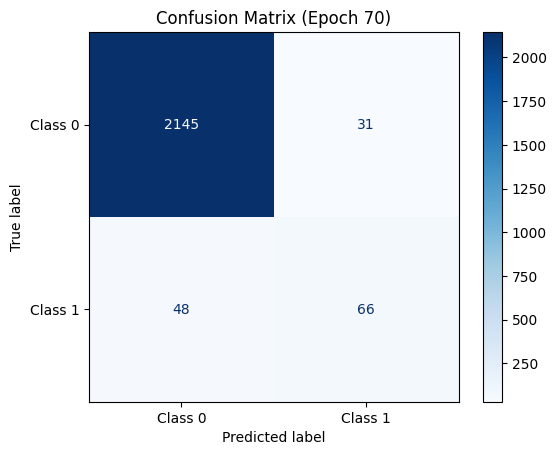

Epoch 71/100, Train Loss: 0.0138, Val Loss: 0.4425, Recall: 52.63%


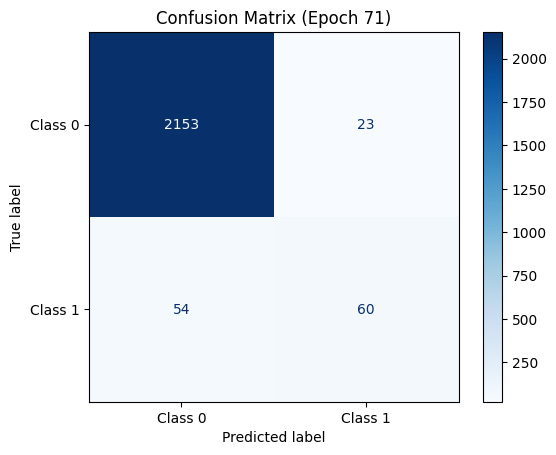

Epoch 72/100, Train Loss: 0.0144, Val Loss: 0.3643, Recall: 64.04%


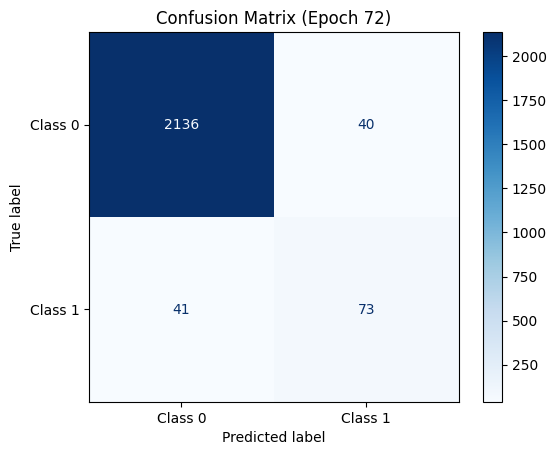

Epoch 73/100, Train Loss: 0.0097, Val Loss: 0.5044, Recall: 55.26%


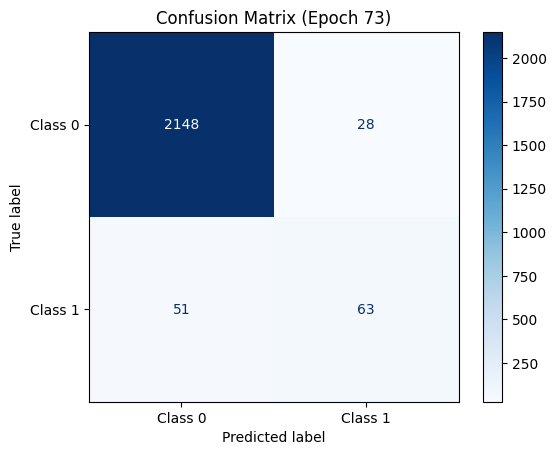

Epoch 74/100, Train Loss: 0.0087, Val Loss: 0.6298, Recall: 50.00%


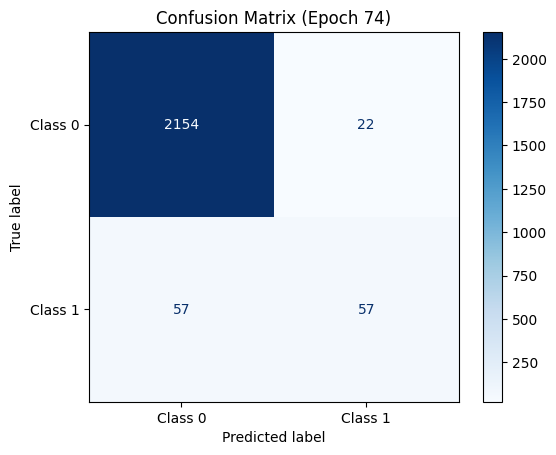

Epoch 75/100, Train Loss: 0.0178, Val Loss: 0.4725, Recall: 50.88%


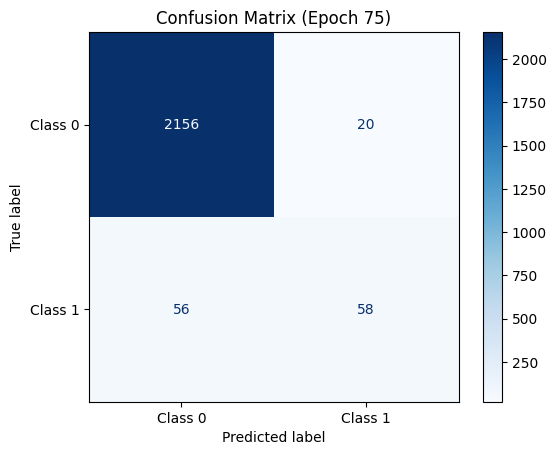

Epoch 76/100, Train Loss: 0.0149, Val Loss: 0.3952, Recall: 58.77%


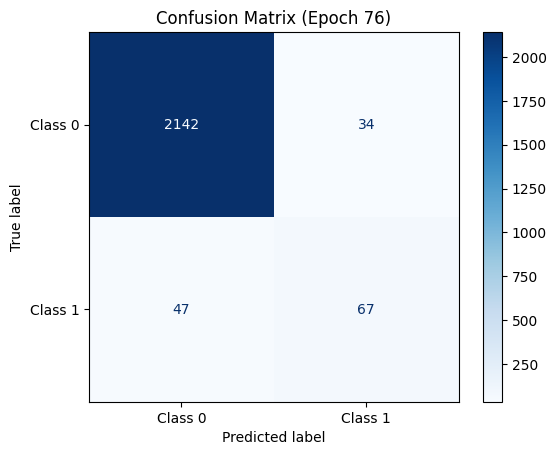

Epoch 77/100, Train Loss: 0.0110, Val Loss: 0.4843, Recall: 47.37%


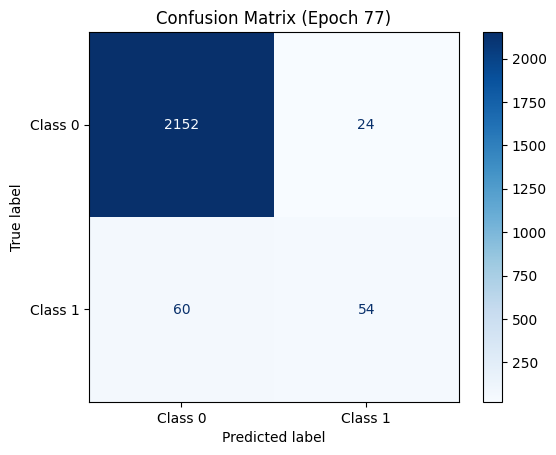

Epoch 78/100, Train Loss: 0.0115, Val Loss: 0.6893, Recall: 47.37%


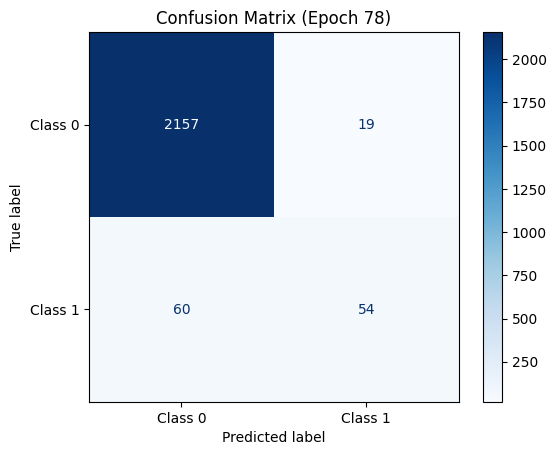

Epoch 79/100, Train Loss: 0.0156, Val Loss: 0.6080, Recall: 47.37%


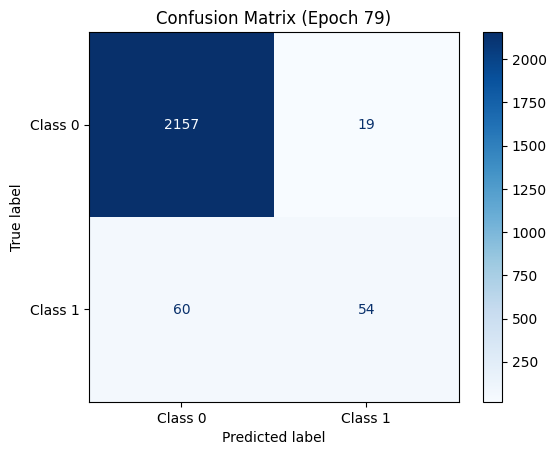

Epoch 80/100, Train Loss: 0.0175, Val Loss: 0.5673, Recall: 45.61%


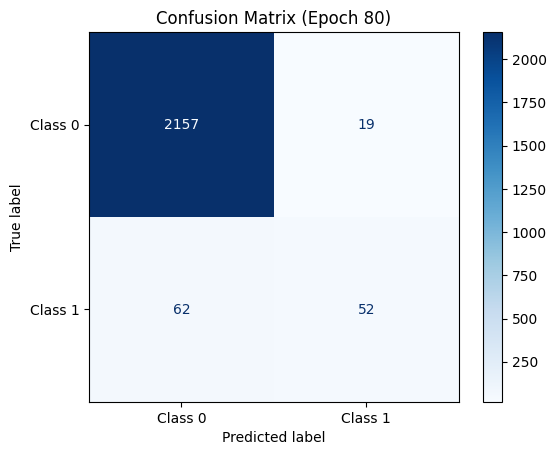

Epoch 81/100, Train Loss: 0.0102, Val Loss: 0.5120, Recall: 57.89%


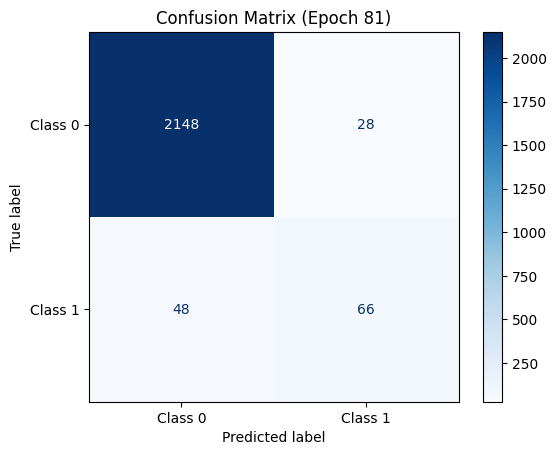

Epoch 82/100, Train Loss: 0.0125, Val Loss: 0.6305, Recall: 47.37%


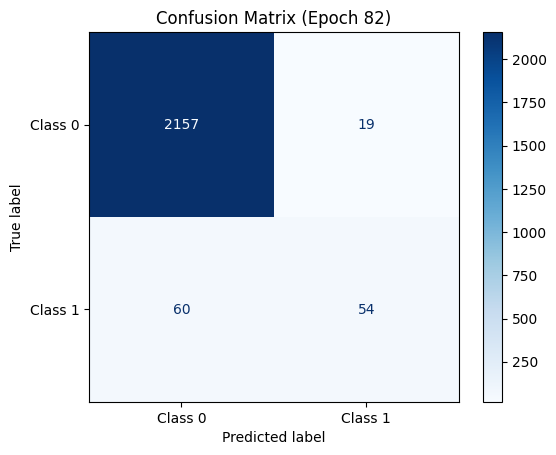

Epoch 83/100, Train Loss: 0.0135, Val Loss: 0.4587, Recall: 58.77%


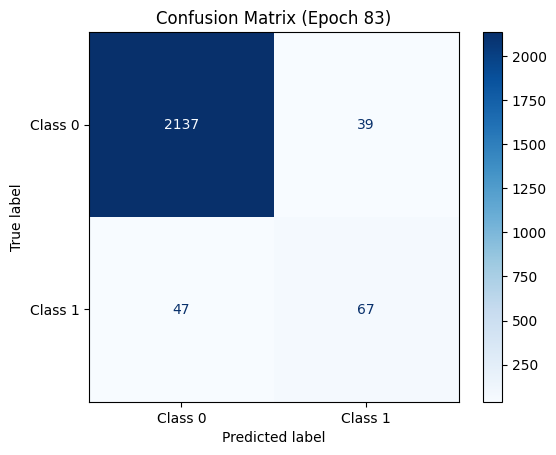

Epoch 84/100, Train Loss: 0.0148, Val Loss: 0.4785, Recall: 57.89%


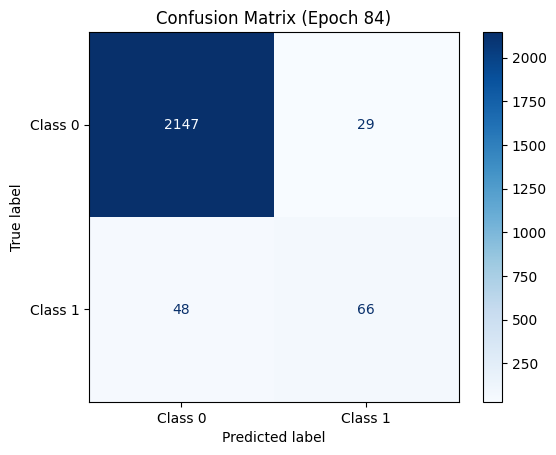

Epoch 85/100, Train Loss: 0.0103, Val Loss: 0.5712, Recall: 56.14%


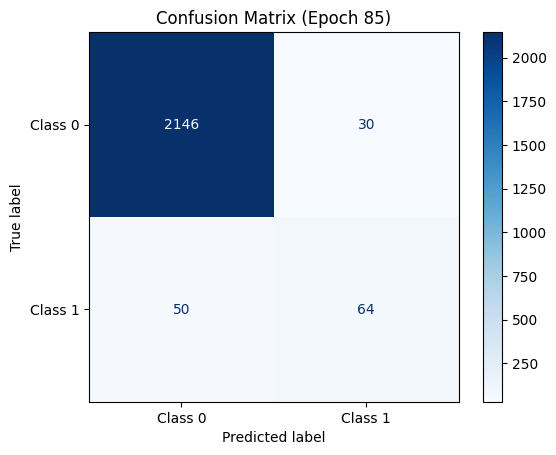

Epoch 86/100, Train Loss: 0.0065, Val Loss: 0.5786, Recall: 66.67%


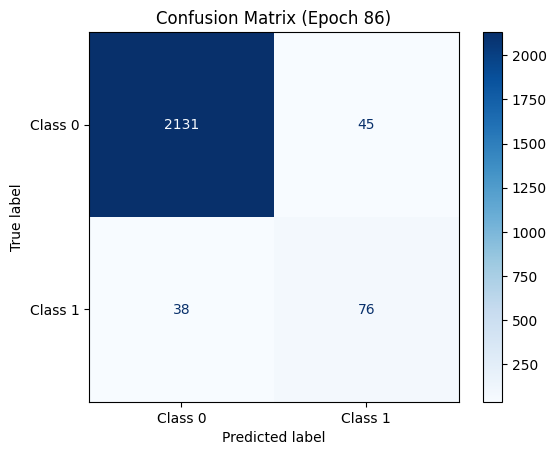

Epoch 87/100, Train Loss: 0.0160, Val Loss: 0.5283, Recall: 46.49%


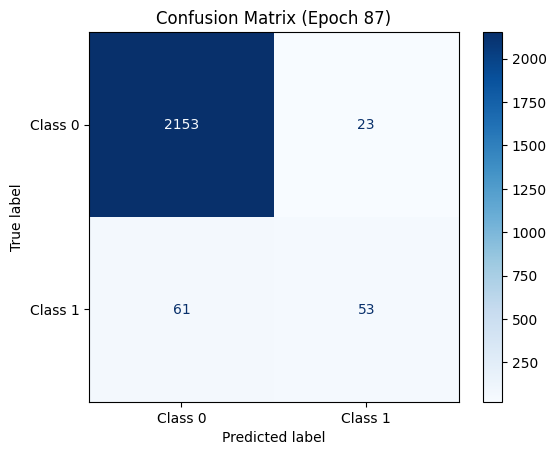

Epoch 88/100, Train Loss: 0.0112, Val Loss: 0.4839, Recall: 60.53%


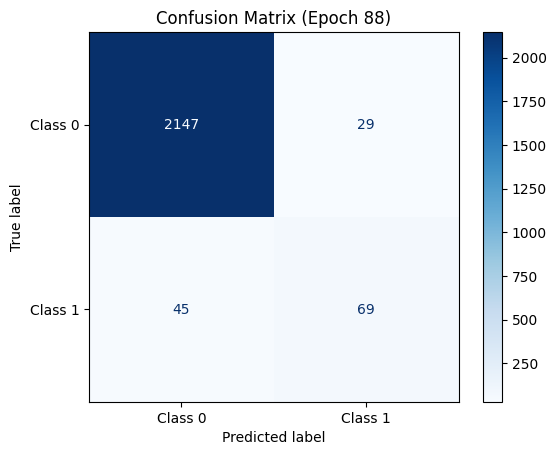

Epoch 89/100, Train Loss: 0.0090, Val Loss: 0.4658, Recall: 57.02%


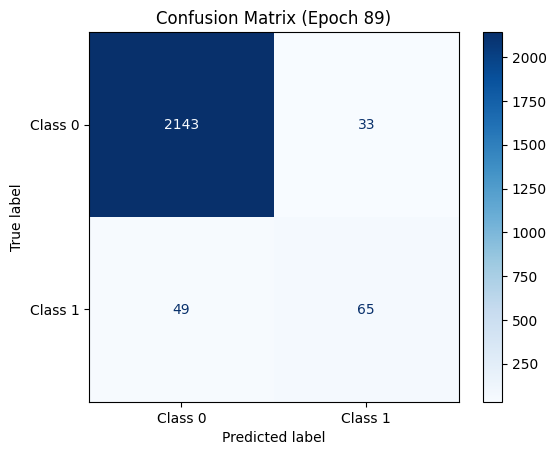

Epoch 90/100, Train Loss: 0.0096, Val Loss: 0.4348, Recall: 63.16%


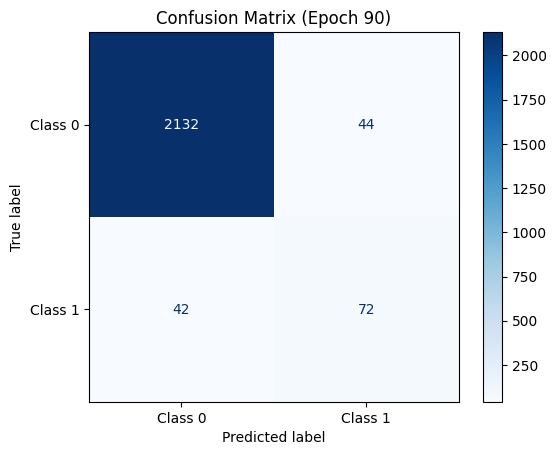

Epoch 91/100, Train Loss: 0.0092, Val Loss: 0.4486, Recall: 52.63%


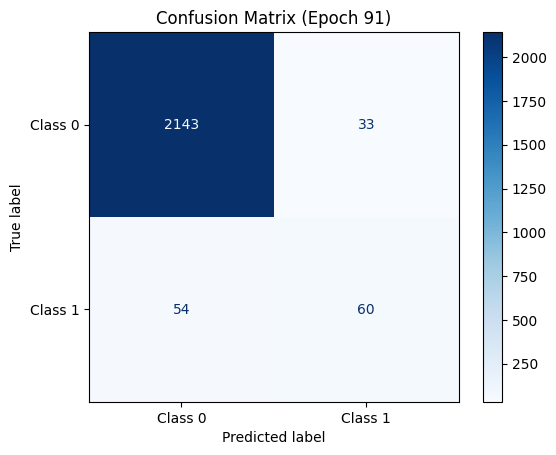

Epoch 92/100, Train Loss: 0.0095, Val Loss: 0.4726, Recall: 57.02%


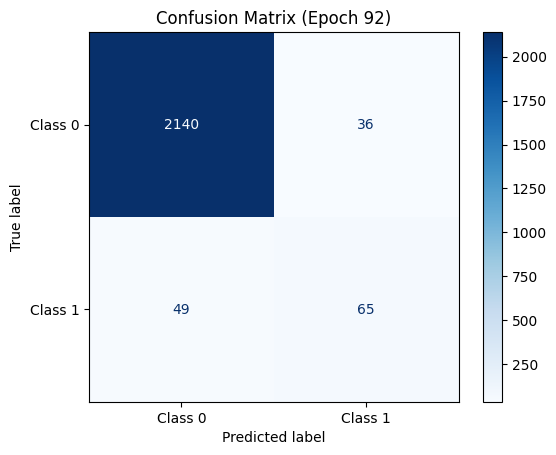

Epoch 93/100, Train Loss: 0.0118, Val Loss: 0.7744, Recall: 44.74%


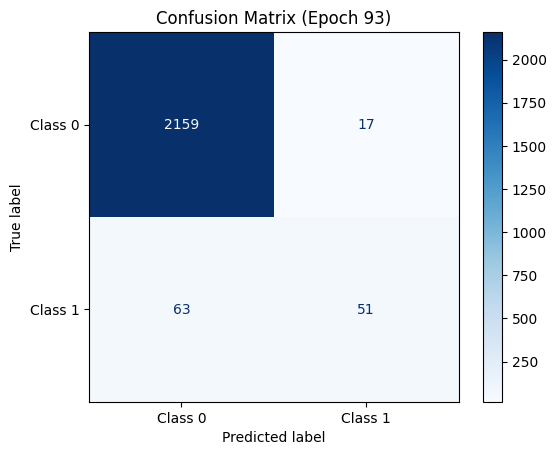

Epoch 94/100, Train Loss: 0.0124, Val Loss: 0.4821, Recall: 54.39%


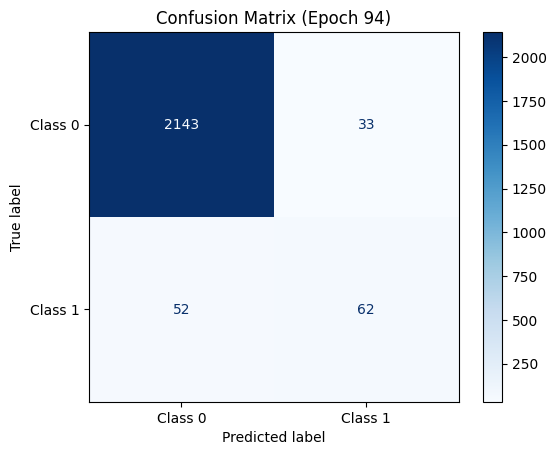

Epoch 95/100, Train Loss: 0.0102, Val Loss: 0.5013, Recall: 47.37%


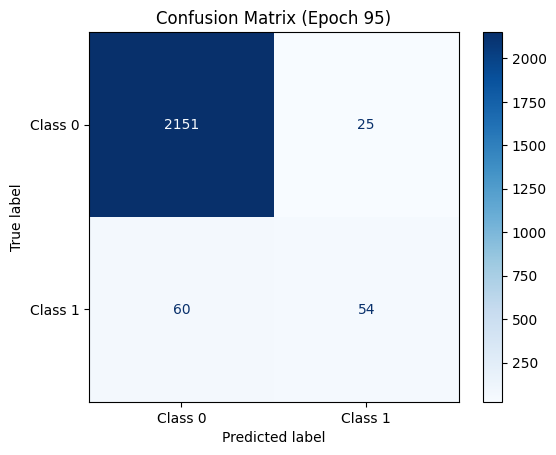

Epoch 96/100, Train Loss: 0.0129, Val Loss: 0.4441, Recall: 54.39%


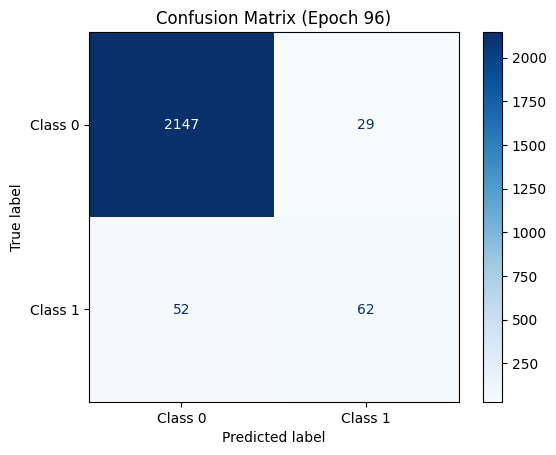

Epoch 97/100, Train Loss: 0.0106, Val Loss: 0.4236, Recall: 64.91%


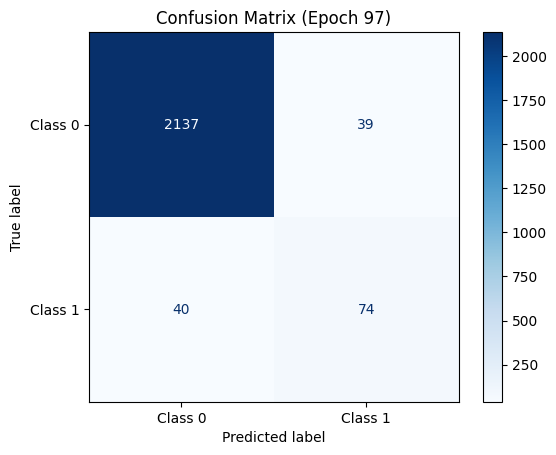

Epoch 98/100, Train Loss: 0.0120, Val Loss: 0.4006, Recall: 56.14%


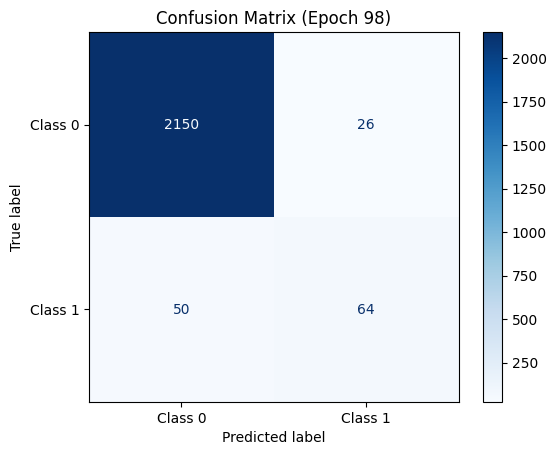

Epoch 99/100, Train Loss: 0.0065, Val Loss: 0.5359, Recall: 55.26%


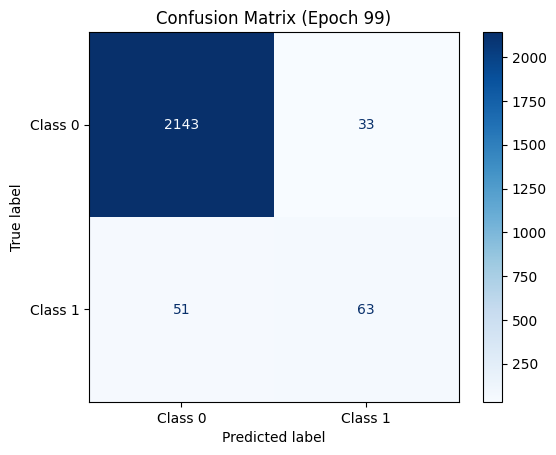

Epoch 100/100, Train Loss: 0.0089, Val Loss: 0.4759, Recall: 69.30%


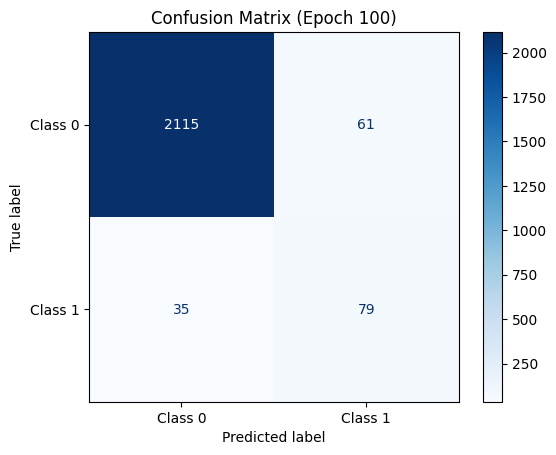

In [20]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

train_model(model, criterion, optimizer, train_data, val_data, 100)

This model gives a much higher recall of 60.53% justifying the fact that a deeper model with more layers is more powerful